# Credit Card Approval Classification Project
## A Prediction Study 
<br>
Cailyn Craven
<br>
CSPB 3022 Spring 2020

## Project Topic 
Banks need to process high volumes of credit card applications. It would be time intensive, and error prone to manually process these applications. It is also critical that applications are properly approved and denied. Banks do not want to take on the risk of issuing cards to consumers who will default on their payments, but they also do not want to deny credit to consumers who would be good customers.  
<br> 
This project involves **predicting** whether someone will be approved for a credit card on the basis their application details. For this **classification task**, the goal is to build a function C(X) that takes as input the feature vector X and predicts its value for Y. The feature vector X is made up of 15 numeric and categorical predictors. Y is a qualitative response that takes values in a finite unordered set of approved or denied.  
<br>
* **Goals**:
<br>
On the basis of the training data, I would like to:
<br>
* Accurately predict approval status of unseen test cases. It is valuable to have an estimate of the probablity that an application should be approved in addition to a binary classification approved or not. 
* Understand which predictors affect the outcome and how. Since I am predicting application approval, but I am also interested in how individual input variables affect the approvals, I am modeling both for prediction and inference. 
* Assess the quality of predictions and inferences. 
<br>
<br>

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
# sns.set() sets the color map to have a light blue background
import seaborn as sns; sns.set()
import patsy
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2 
from sklearn import linear_model
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
import sklearn.neighbors as neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_predict
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data Source and Description
This project uses the Credit Card Approval dataset from the UCI Machine Learning Repository. http://archive.ics.uci.edu/ml/datasets/credit+approval
<br>
This dataset is a collection of credit card applications and the credit approval decisions from a financial institution. The dataset is in the form of a CSV file with 14 predictors and 1 output variable (the approval status). Interestingly, since the dataset includes real financial data, the approval status of each application is given. The names and values of the predictors have been anonymized to protect consumer confidentialty.    
<br>

In [2]:
# load in the dataset from the UCI Machine Learning Repository
# http://archive.ics.uci.edu/ml/datasets/credit+approval
# missing values have been marked with question marks, fill those in this step
cc_df = pd.read_csv('crx.data', header=None, na_values=['?'])

In [3]:
# the data values look confusing when loaded in
# The UCI page has a note:
# "All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data."
cc_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


In [4]:
# get a sense of the factor data types 
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
0     678 non-null object
1     678 non-null float64
2     690 non-null float64
3     684 non-null object
4     684 non-null object
5     681 non-null object
6     681 non-null object
7     690 non-null float64
8     690 non-null object
9     690 non-null object
10    690 non-null int64
11    690 non-null object
12    690 non-null object
13    677 non-null float64
14    690 non-null int64
15    690 non-null object
dtypes: float64(4), int64(2), object(10)
memory usage: 86.4+ KB


## Factors
This dataset has a good mix of attribute types -- continuous, nominal with a small numbers of values, and nominal with a larger numbers of values. Some values are missing. There are 690 total data objects so n is relatively small with a larger p since there are 15 predictors. 
<br>
Other researchers working with this dataset have assigned probable names to the attributes. <br> 
One such example is: http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html <br>
As part of the exploratory data analysis, I will be evaluating whether these seem like reasonable attribute names.  
<br>
*Includes probable column in parentheses <br>
1:	categorical with two possible values b, a (Gender) <br>
2:	continuous (Age) <br>
3:	continuous (Debt) <br>
4:	categorical with 4 possible values u, y, l, t  (Marital Status) <br>
5:	categorical with 3 possible values g, p, gg  (Bank Customer)  <br>
6:	categorical with 14 possible values (Education level) <br>
7:	categorical with 9 possible values (Ethnicity) <br>
8:	continuous (Years Employed)  <br>
9:	categorical with 2 possible values t,f (Prior Default) <br>
10:	categorical with 2 possible values t,f  (Employed) <br>
11:	continuous (Credit Score) <br>
12:	categorical with 2 possible values t,f (Driver's License) <br>
13:	categorical with 3 possible values g, p, s (Citizen) <br>
14:	continuous (Zip Code) <br>
15:	continuous (Income) <br>
16: +,- (class attribute) (Approved: Yes or No) 

## Real World Application
The Equal Credit Opportunity Act (ECOA) is a federal law that prohibits lenders from discriminating against anyone based on protected status. Lending institutions cannot discriminate based on: race, color, religion, national origin, sex, marital status, age, or receiving money from public assistance. https://files.consumerfinance.gov/f/documents/201703_cfpb_handout_ECOA_helping_consumers.pdf <br> 
I will be exploring whether it looks like approval decisions are associated with ethnicity, gender, marital status, or age, suggesting potential bias or discrimination. 

## Exploration of Data Values and Data Types
Reference if this if necessary, otherwise feel free to move on to the EDA section. 

In [5]:
# this column is likely 'Gender'
cc_df[0].unique()

array(['b', 'a', nan], dtype=object)

In [6]:
# this column is likely 'Age'
cc_df[1].head()

0    30.83
1    58.67
2    24.50
3    27.83
4    20.17
Name: 1, dtype: float64

In [7]:
# this column is likely 'Debt'
cc_df[2].head()

0    0.000
1    4.460
2    0.500
3    1.540
4    5.625
Name: 2, dtype: float64

In [8]:
# this column is likely marital status 
# thought this was going to have 4 values
# only has 3 and then missing values 
cc_df[3].unique()

array(['u', 'y', nan, 'l'], dtype=object)

In [9]:
# this column is likely bank customer
cc_df[4].unique()

array(['g', 'p', nan, 'gg'], dtype=object)

In [10]:
# this column is likely education level 
# does that seem right? 
# what are all of these levels? 
cc_df[5].unique()

array(['w', 'q', 'm', 'r', 'cc', 'k', 'c', 'd', 'x', 'i', 'e', 'aa', 'ff',
       'j', nan], dtype=object)

In [11]:
# this column is likely ethnicity 
cc_df[6].unique()

array(['v', 'h', 'bb', 'ff', 'j', 'z', nan, 'o', 'dd', 'n'], dtype=object)

In [12]:
# this column is likely 'Years Employed'
cc_df[7].head()

0    1.25
1    3.04
2    1.50
3    3.75
4    1.71
Name: 7, dtype: float64

In [13]:
# this column is like 'Prior Default'
cc_df[8].unique()

array(['t', 'f'], dtype=object)

In [14]:
# this column is likely 'Employed'
cc_df[9].unique()

array(['t', 'f'], dtype=object)

In [15]:
# this column is likely 'Credit Score'
cc_df[10].head()

0    1
1    6
2    0
3    5
4    0
Name: 10, dtype: int64

In [16]:
# this column is likely 'Driver's License'
cc_df[11].unique()

array(['f', 't'], dtype=object)

In [17]:
# this column is likely Citizen 
cc_df[12].unique()

array(['g', 's', 'p'], dtype=object)

In [18]:
# this column is likely Zip Code
cc_df[13].head()

0    202.0
1     43.0
2    280.0
3    100.0
4    120.0
Name: 13, dtype: float64

In [19]:
# this column is likely Income
cc_df[14].head()

0      0
1    560
2    824
3      3
4      0
Name: 14, dtype: int64

In [20]:
# this is the outcome variable
# whether the application was approved or denied
cc_df[15].unique()

array(['+', '-'], dtype=object)

# Data Cleaning and Exploratory Data Analysis 


In [21]:
# set headers based on probable attribute names 
header = {0:'Gender', 1:'Age', 2:'Debt', 3:'Married', 4:'Bank Customer', 
          5:'Education Level', 6:'Ethnicity', 7:'Years Employed',
          8:'Prior Default', 9:'Employed', 10:'Credit Score',
          11:'Driver\'s License', 12:'Citizen', 13:'Zip Code', 
          14: 'Income', 15:'Approved'}

In [22]:
# Rename the dataframe's column values with the header variable
cc_df = cc_df.rename(columns = header)

## Basic Statistics of the Data

In [23]:
# basic statistical descriptions of the data 
cc_df.describe()

,Age,Debt,Years Employed,Credit Score,Zip Code,Income
count,678.000000,690.000000,690.000000,690.00000,677.000000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,184.014771,1017.385507
std,11.957862,4.978163,3.346513,4.86294,173.806768,5210.102598
min,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,22.602500,1.000000,0.165000,0.00000,75.000000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,160.000000,5.000000
75%,38.230000,7.207500,2.625000,3.00000,276.000000,395.500000
max,80.250000,28.000000,28.500000,67.00000,2000.000000,100000.000000


## Numeric Factors
For each numeric factor, use a box-plot, scatter plot, histogram, or KDE plot to describe the distribution of the data as appropriate.

In [24]:
numeric_cols = ['Age', 'Debt', 'Years Employed', 
               'Credit Score', 'Zip Code', 'Income']

In [25]:
# boxplot plotting function 
def boxplot(x, df):
    sns.boxplot( x=df[x], width=0.3);
    plt.title(x, fontsize=18)
    plt.show();

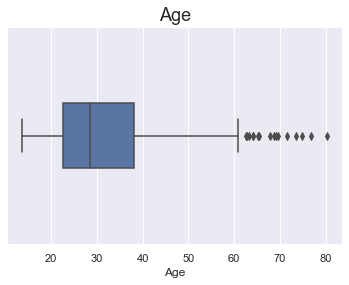

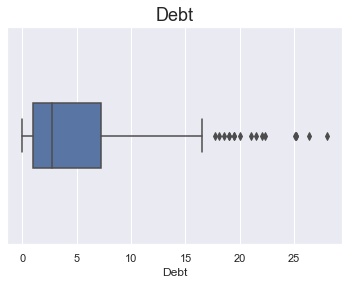

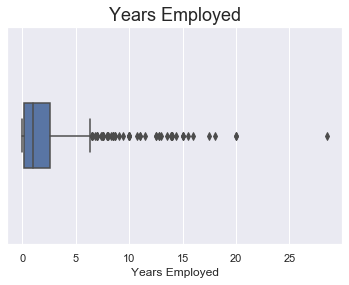

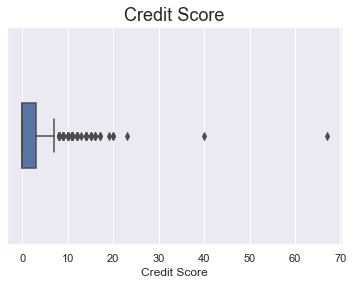

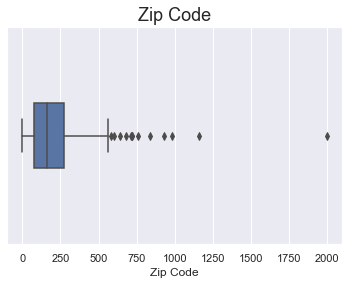

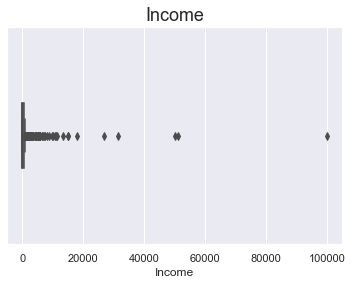

In [26]:
# create a boxplot of numeric columns in the dataset 
for i in range(len(numeric_cols)):
    boxplot(numeric_cols[i], cc_df)

In [27]:
# histogram plotting function with KDE overlay 
# plot mean as a red line 
def hist_plot(x, df):
    sns.distplot(df[x], color='blue')
    plt.title(x, fontsize=18)
    plt.xlabel(x, fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    mean = df[x].mean()
    plt.axvline(mean,color='red');
    plt.show();

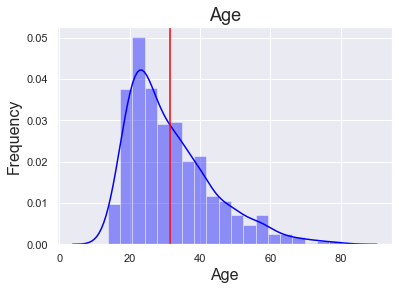

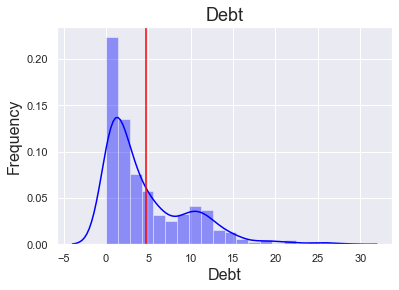

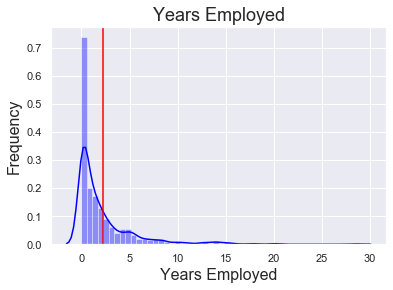

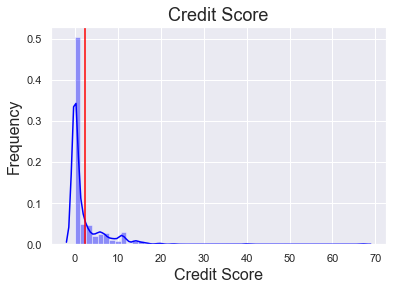

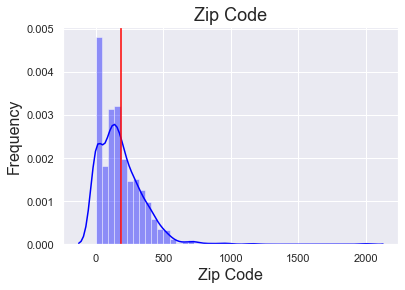

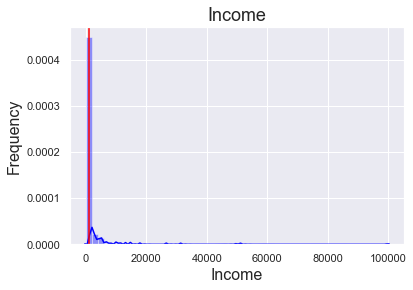

In [28]:
for i in range(len(numeric_cols)):
    hist_plot(numeric_cols[i], cc_df)

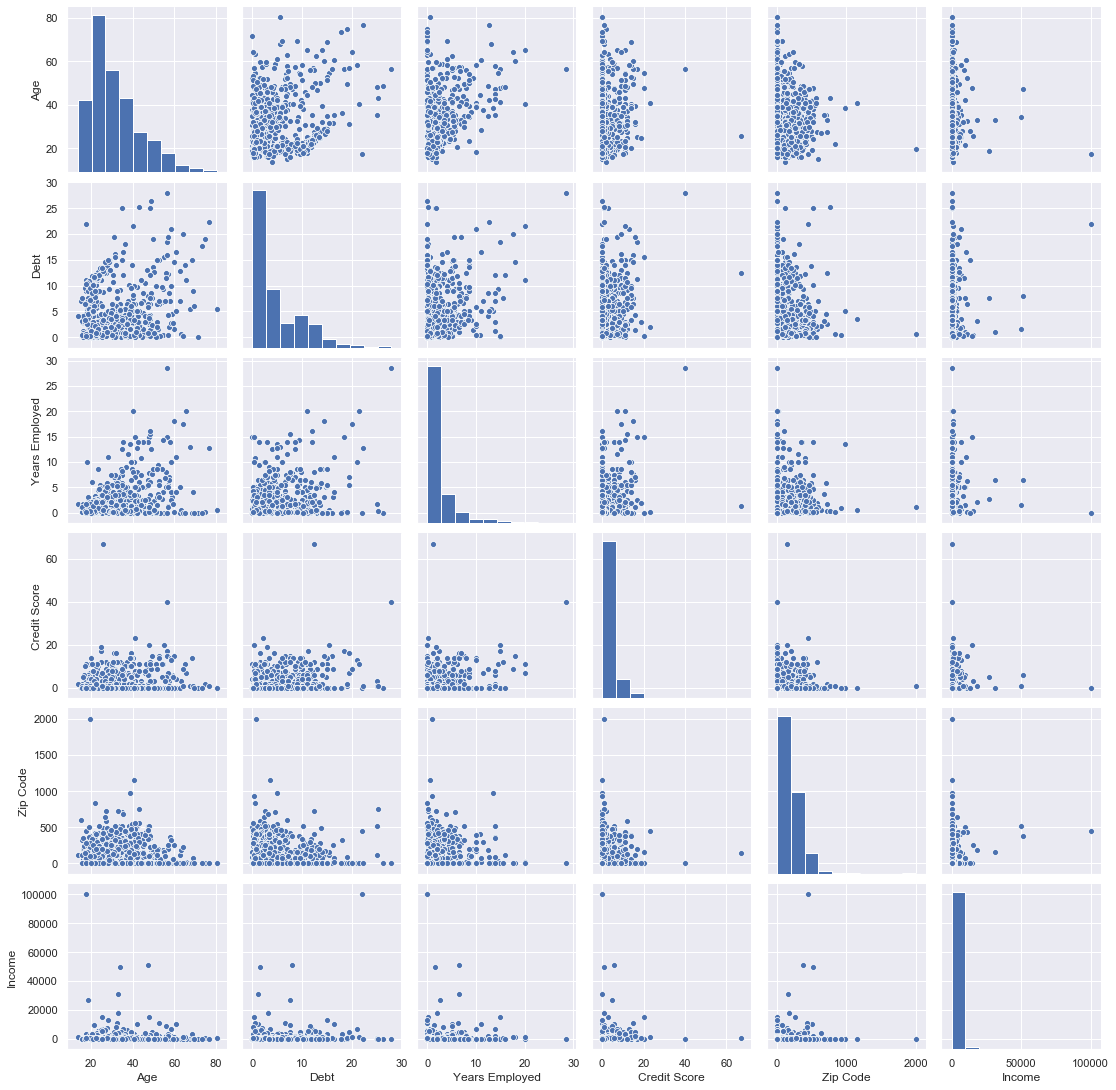

In [29]:
# create pairplots of all numeric factors in the dataset 
sns.pairplot(cc_df)

One of the benefits of these plots is that it helps with an analysis of whether the probable attribute names are reasonable. <br>
* **Age**: I would expect age to have a normal distribution. The histogram for age shows a bell curve type shape. The boxplot shows a Q1 value of 22.62 which seems like a reasonable younger age at which people apply for credit cards. The variable is right skewed with some outlier values above 60.<br>
* The rest of the numeric factors ('Age', 'Debt', 'Years Employed', 'Credit Score', 'Zip Code', 'Income') are more strongly **right skewed**. I would expect income to be highly skewed so for the most part these distributions make sense with the probable labels.<br>
*  Income has the least amount of variance because the boxes are tightly grouped about the mean. <br>
* I was uncertain about zip codes. It looks like the first numbers of a zip-code signify the region where an address is located, and the number grows from the east coast to west. (https://www.womansday.com/life/a51100/the-history-and-meaning-of-zip-codes/) It would make sense for the customers of a financial institution to have zip codes that are close together. A zip code would be a nominal variable represented by numbers. Since labels are only a guess, I am going to leave the zip codes in with the numeric data. <br>
* Since the numeric variables are so highly skewed to the right, they may be good candidates for log transformation or some other transformation. 

## Correlation Between Numeric Variables 

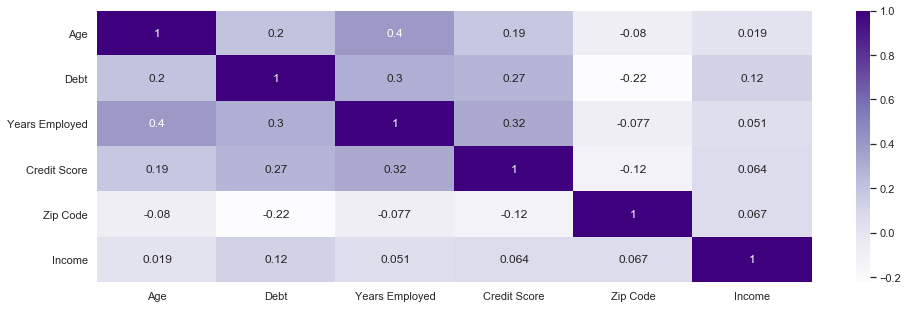

In [30]:
# matrix for correlation between numeric variables 
fig, ax = plt.subplots(figsize=(16,5))
correlation = cc_df.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True, ax=ax, cmap="Purples");

The attribute labeled "Zip Code" has a negative correlation with the rest of the numeric variables. 
The rest of the variables have positive correlations represented by positive correlation coefficients. <br> 
1 represents perfect positive correlation, and -1 represents perfect positive correlation. 
The Wikipedia article about "Multicollinearity" says, "Correlation values (off-diagonal elements) of at least 0.4 are sometimes interpreted as indicating a multicollinearity problem."
The correlation matrix above shows that factors with correlations of at least 0.4 are:
* Years Employed with Age <br>
The scatterplot of Years Employed vs Age looks like it could be represented by linear regression, but there would be a lot of noise. It could be assumed that a strong correlation coefficient has an absolute value greater than or equal to 0.7. None of the numeric factors have a correlation that strong. <br>
The pairwise scatterplots for the result of the numeric attributes look as expected for values at or below 0.4 showing low correlation. <br>


## Data Cleaning: Fill Missing Numeric Values with Median 
There are a small number of missing values for numeric attributes in the dataset. Median imputation is a better choice than mean imputation in this case because of the skewed nature of the data.  

In [31]:
# Count the number of NaNs in dataset 
cc_df.isnull().sum()

Gender              12
Age                 12
Debt                 0
Married              6
Bank Customer        6
Education Level      9
Ethnicity            9
Years Employed       0
Prior Default        0
Employed             0
Credit Score         0
Driver's License     0
Citizen              0
Zip Code            13
Income               0
Approved             0
dtype: int64

In [32]:
# Impute the missing values with median imputation
# fills with the median value for each column 
# since the numeric columns have skewed distributions 
cc_df.fillna(cc_df.median(), inplace=True)

In [33]:
# Count the number of NaNs in dataset
# verify no NaNs in numeric columns 
cc_df.isnull().sum()

Gender              12
Age                  0
Debt                 0
Married              6
Bank Customer        6
Education Level      9
Ethnicity            9
Years Employed       0
Prior Default        0
Employed             0
Credit Score         0
Driver's License     0
Citizen              0
Zip Code             0
Income               0
Approved             0
dtype: int64

## Scatterplot for Correlation Between Years Employed and Age 

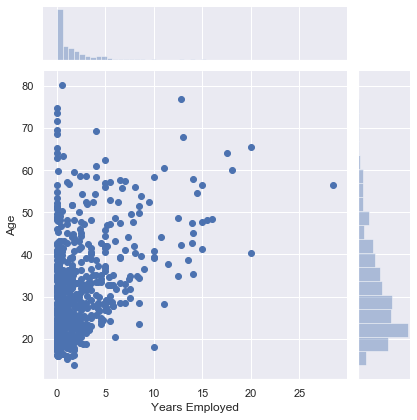

In [34]:
sns.jointplot(x='Years Employed', y='Age', data=cc_df)

## Categorical Factors

## Data Cleaning: Fill Missing Categorical Values with Most Frequently Occurring Value 

In [35]:
# For the categorical factors,
# it is problematic to create barplots
# with missing values. 
# Count the number of NaNs in dataset
# verify no NaNs in numeric columns 
cc_df.isnull().sum()

Gender              12
Age                  0
Debt                 0
Married              6
Bank Customer        6
Education Level      9
Ethnicity            9
Years Employed       0
Prior Default        0
Employed             0
Credit Score         0
Driver's License     0
Citizen              0
Zip Code             0
Income               0
Approved             0
dtype: int64

In [36]:
# for the categorical columns 
# fill missing values with the most frequent values
# Iterate over each column of cc_apps
for col in cc_df:
    # Check if the column is of object type
    if cc_df[col].dtypes == 'object':
        # Impute with the most frequent value
        cc_df = cc_df.fillna(cc_df[col].value_counts().index[0])

In [37]:
# Count the number of NaNs in the dataset and print the counts to verify
cc_df.isnull().sum()

Gender              0
Age                 0
Debt                0
Married             0
Bank Customer       0
Education Level     0
Ethnicity           0
Years Employed      0
Prior Default       0
Employed            0
Credit Score        0
Driver's License    0
Citizen             0
Zip Code            0
Income              0
Approved            0
dtype: int64

In [38]:
# barplot function  
def bar_plot(x, df):
    count = df[x].value_counts()
    sns.barplot(count.index, count.values, alpha=0.8)
    plt.title(x, fontsize=18)
    plt.xlabel(x, fontsize=16)
    plt.ylabel('Number of Occurrences', fontsize=16)
    plt.show();

In [39]:
categorical_cols = ['Gender', 'Married', 'Bank Customer',
                   'Education Level', 'Ethnicity', 
                   'Prior Default', 'Employed', 'Driver\'s License',
                   'Citizen', 'Approved'] 

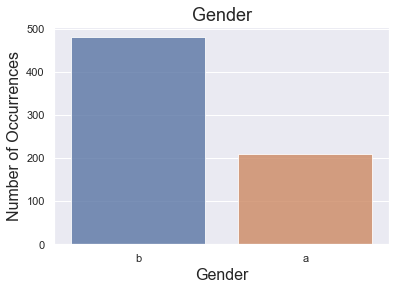

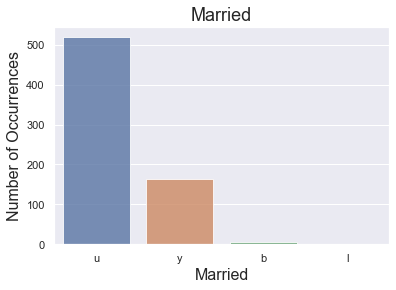

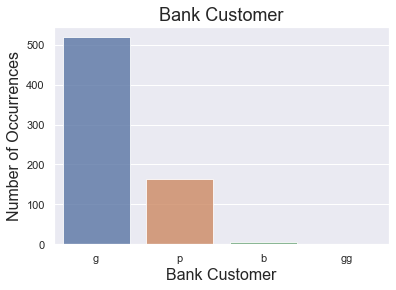

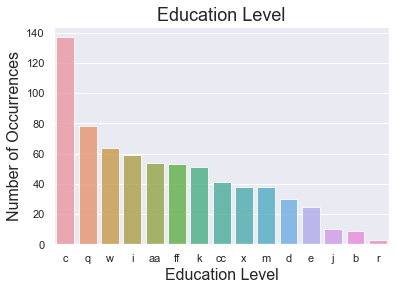

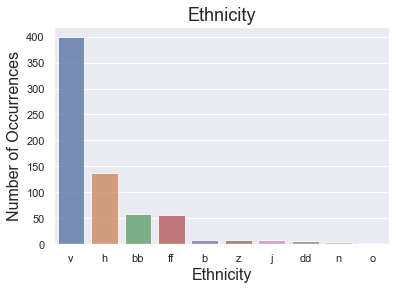

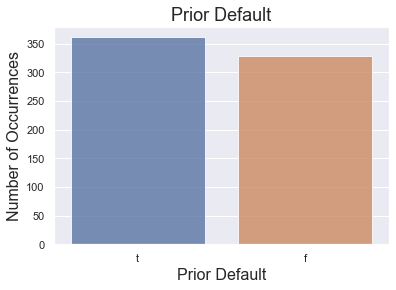

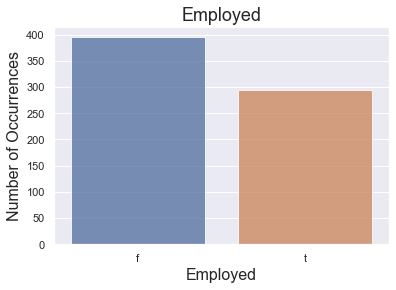

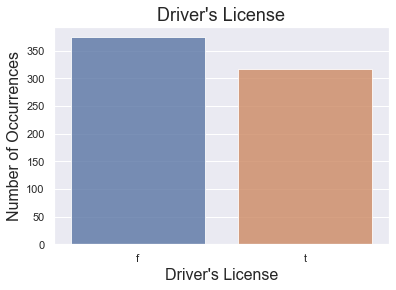

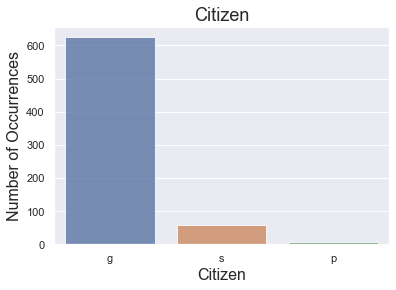

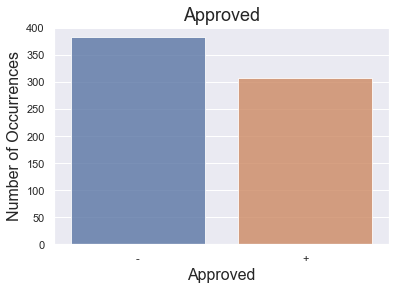

In [40]:
for i in range(len(categorical_cols)):
    bar_plot(categorical_cols[i], cc_df)

From the barplots, we can see that many of the categorical variables are not uniformly distributed. <br>
* For Gender, Married, Bank Customer, Education Level, Ethnicity, and Citizen, the counts of variables look very different with some variables having much higher counts than others.<br>
* Prior Default and Employed don't have the same counts in each category, but the counts are closer together. <br>
* The barplot for the output variable Approved shows that about 375 applications were denied and 300 were approved. Therefore, the dataset looks pretty balanced. There isn't one classification that is rare. 

## Correlation Between Categorical Variables 
Describe correlations between different factors of the dataset. To look for correlations for categorical variables, first it will be easier to encode all categorical values as numeric values. 

## Data Type Munging
Convert all categorical variables to numeric variables. This will speed up computation time. It will also allow us to mix numeric and qualitative variables in the same models. 

## Data Transformations: Encode All Attributes As Numeric
 

In [41]:
# encode + and - separately so they make intuitive sense
# with 1 representing approved 
# and 0 representing denied 
cc_df['Approved'].replace(['-','+'],[0,1],inplace=True)

In [42]:
# convert categorical variables to numbers 
# instantiate sklearn LabelEncoder
le = preprocessing.LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in cc_df:
    # Compare if the dtype is object
    if cc_df[col].dtypes == 'object':
    # Use LabelEncoder to do the numeric transformation
        le.fit(cc_df[col])
        cc_df[col]=le.transform(cc_df[col])

In [43]:
# check column dtypes 
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
Gender              690 non-null int64
Age                 690 non-null float64
Debt                690 non-null float64
Married             690 non-null int64
Bank Customer       690 non-null int64
Education Level     690 non-null int64
Ethnicity           690 non-null int64
Years Employed      690 non-null float64
Prior Default       690 non-null int64
Employed            690 non-null int64
Credit Score        690 non-null int64
Driver's License    690 non-null int64
Citizen             690 non-null int64
Zip Code            690 non-null float64
Income              690 non-null int64
Approved            690 non-null int64
dtypes: float64(4), int64(12)
memory usage: 86.4 KB


In [44]:
# create filtered version of DataFrame 
# only has categorical columns 
categorical_df = cc_df[categorical_cols]
categorical_df.head()

,Gender,Married,Bank Customer,Education Level,Ethnicity,Prior Default,Employed,Driver's License,Citizen,Approved
0,1,2,1,13,8,1,1,0,0,1
1,0,2,1,11,4,1,1,0,0,1
2,0,2,1,11,4,1,0,0,0,1
3,1,2,1,13,8,1,1,1,0,1
4,1,2,1,13,8,1,0,0,2,1


In [45]:
# check data types 
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 10 columns):
Gender              690 non-null int64
Married             690 non-null int64
Bank Customer       690 non-null int64
Education Level     690 non-null int64
Ethnicity           690 non-null int64
Prior Default       690 non-null int64
Employed            690 non-null int64
Driver's License    690 non-null int64
Citizen             690 non-null int64
Approved            690 non-null int64
dtypes: int64(10)
memory usage: 54.0 KB


In [46]:
# make sure it has no null values 
categorical_df.isnull().sum()

Gender              0
Married             0
Bank Customer       0
Education Level     0
Ethnicity           0
Prior Default       0
Employed            0
Driver's License    0
Citizen             0
Approved            0
dtype: int64

In [47]:
# compare each of the categorical predictors 
# with approval 
X = categorical_df.drop('Approved',axis=1)
y = categorical_df['Approved']

In [48]:
# Compute chi-squared stats between each non-negative feature and class.
chi_scores, p_values = chi2(X,y)
print(chi_scores)

[1.75809655e-01 2.59347063e+00 1.22210090e+01 3.43201841e+01
 5.95178003e-04 1.70746388e+02 8.29658437e+01 3.74048205e-01
 1.23386457e+01]


In [49]:
print(len(chi_scores))

9


In [50]:
categorical_list = list(categorical_df.drop('Approved',axis=1))
print(categorical_list)

['Gender', 'Married', 'Bank Customer', 'Education Level', 'Ethnicity', 'Prior Default', 'Employed', "Driver's License", 'Citizen']


In [51]:
print(len(categorical_list))

9


In [52]:
print(chi_scores)

[1.75809655e-01 2.59347063e+00 1.22210090e+01 3.43201841e+01
 5.95178003e-04 1.70746388e+02 8.29658437e+01 3.74048205e-01
 1.23386457e+01]


In [53]:
categorical_dict = {}
c = 0 
for i in categorical_list: 
    categorical_dict[i] = chi_scores[c]
    c += 1 
print(categorical_dict)

{'Gender': 0.17580965462107162, 'Married': 2.593470633041039, 'Bank Customer': 12.221008960167504, 'Education Level': 34.32018414959872, 'Ethnicity': 0.0005951780028933637, 'Prior Default': 170.74638754951758, 'Employed': 82.96584366867756, "Driver's License": 0.37404820528245675, 'Citizen': 12.33864565773354}


The null hypothesis for chi2 test is that "two categorical variables are independent". So a higher value of chi2 statistic means "two categorical variables are dependent" and therefore more useful for classification. 
For a 2x2 contingency table, a Chi Square Table shows that values above 5.99 have significance at the 0.05 level.
http://www.ttable.org/chi-square-table.html
The attributes that have Chi Square values above 5.99 for that feature and Approval status are: 
* Bank Customer
* Education Level
* Prior Default
* Employed
* Citizen 
 

In [54]:
# Count the number of NaNs in dataset 
cc_df.isnull().sum()

Gender              0
Age                 0
Debt                0
Married             0
Bank Customer       0
Education Level     0
Ethnicity           0
Years Employed      0
Prior Default       0
Employed            0
Credit Score        0
Driver's License    0
Citizen             0
Zip Code            0
Income              0
Approved            0
dtype: int64

## Data Transformations: Scale the Data
I am planning to use a KNN method for prediction. The numeric values had a much wider range of values before the log transformation. With the raw values, there were attributes like debt that ranged from 0 to 28 and others like income that ranged from 0 to 100000. Even after the log transformation, there are still differences in the ranges of numeric and categorical attributes. For example, many of the categorical attributes are binary, but there are attributes like ethnicity and education level that have a greater number of values. sklearn.preprocessing has an option to scale all attributes to a 0-1 range. 

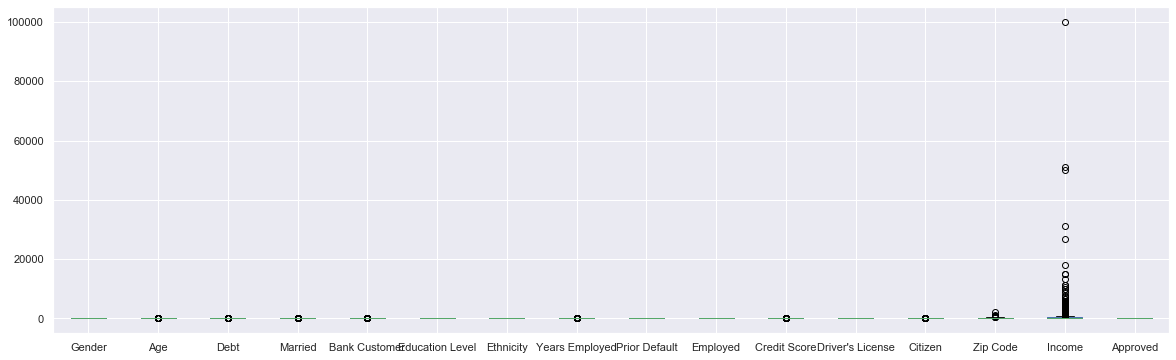

In [55]:
# boxplot for each attribute showing ranges in values 
cc_df.plot.box(figsize=(20,6));

## Cleaning: Remove Outliers 
Boxplots show outlier values outside out of the whiskers. These outliers represent values less than Q1 - 1.5 * IQR and more than Q3 + 1.5 * IQR where IQR is the interquartile range Q3 - Q1. This method of outlier detection and cleaning requires that the data follows a somewhat normal distribution prior to removing outliers so that valuable data points aren't removed. The attributes in this dataset do not follow a somewhat normal distribution so this is not an appropriate method. Instead, I will be visually inspecting and cleaning each of the 15 input variables.   

## Inspection

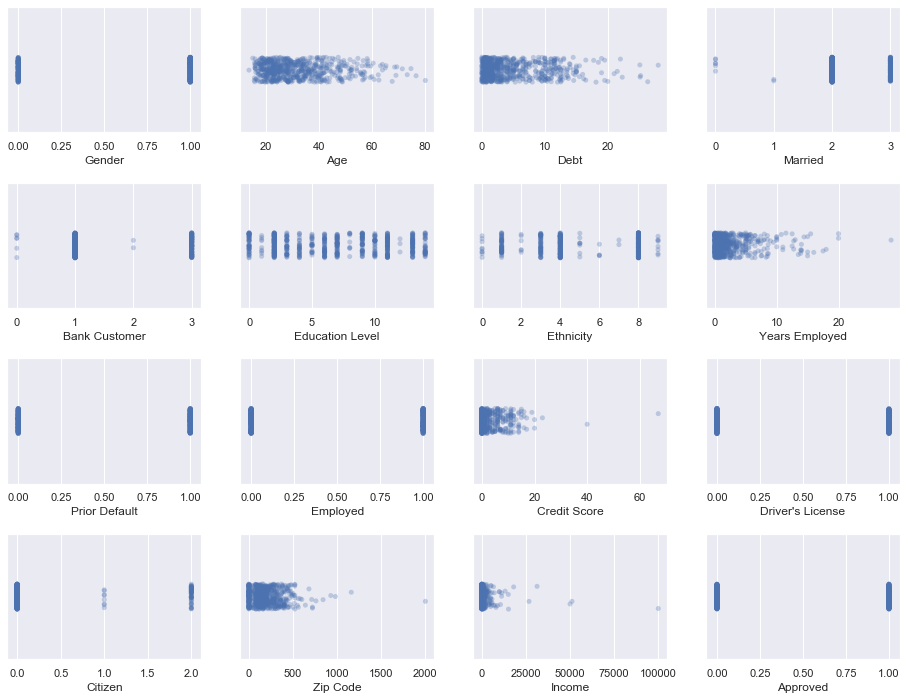

In [56]:
# create strip plots to help identify outliers 
fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(16,12))
plt.subplots_adjust(hspace=0.4)     # spacing between subplots

c = 0;
# create strip plots of all variables
for k in range(4):     # going through row of subplot
    for i in range(4):     # going through column of subplot
        sns.stripplot(cc_df[cc_df.columns[c]], data=cc_df, jitter=True, alpha=0.3, ax=ax[k][i]);
        ax[k][i].set_xlabel(cc_df.columns[c])
        c += 1

## Outlier Inspection
Although I created strip plots of all variables, I am focusing my attention on numeric variables. 
* **Age**: Values above 60 are more spread out. The lowest value could be an erroneous entry. You need to be 18 years old to receive a credit card even with a co-signer. A particularly low value separated from the rest of the data has a high likelihood of being an error. 
* For **debt** none of the values look like clear outliers.
* For **years employed**, some of the values separate out more above 10, but the only value clearly separated from the rest of the data is the value above 20.
* For **credit score** the two values above 30 appear to be separated from the rest of the data. 
* For **zip code** the values above 1000 look like outliers.
* For **income** the values above 25000 are more spread out. Remove values above 25000. 

## Outlier Cleaning 

In [57]:
# number of rows in DataFrame
# before we start cleaning 
len(cc_df)

690

In [58]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
Gender              690 non-null int64
Age                 690 non-null float64
Debt                690 non-null float64
Married             690 non-null int64
Bank Customer       690 non-null int64
Education Level     690 non-null int64
Ethnicity           690 non-null int64
Years Employed      690 non-null float64
Prior Default       690 non-null int64
Employed            690 non-null int64
Credit Score        690 non-null int64
Driver's License    690 non-null int64
Citizen             690 non-null int64
Zip Code            690 non-null float64
Income              690 non-null int64
Approved            690 non-null int64
dtypes: float64(4), int64(12)
memory usage: 86.4 KB


In [59]:
ageMin = cc_df['Age'].min()
print(ageMin)

13.75


In [60]:
outlier_df = cc_df.loc[(cc_df['Age']< 13.75) | (cc_df['Years Employed'] > 20) | 
          (cc_df['Credit Score']> 30) | (cc_df['Zip Code']> 1000) |
          (cc_df['Income']> 25000)]
outlier_df.head()

,Gender,Age,Debt,Married,Bank Customer,Education Level,Ethnicity,Years Employed,Prior Default,Employed,Credit Score,Driver's License,Citizen,Zip Code,Income,Approved
6,1,33.17,1.04,2,1,12,4,6.50,1,0,0,1,0,164.0,31285,1
44,1,56.42,28.00,3,3,2,8,28.50,1,1,40,0,0,0.0,15,1
65,1,34.17,1.54,2,1,3,8,1.54,1,1,1,1,0,520.0,50000,1
121,1,25.67,12.50,2,1,3,8,1.21,1,1,67,1,0,140.0,258,1
132,0,47.42,8.00,2,1,5,1,6.50,1,1,6,0,0,375.0,51100,1


In [61]:
index_list = list(outlier_df.index)
print(index_list)

[6, 44, 65, 121, 132, 243, 317, 327, 407]


In [62]:
print(len(index_list))

9


In [63]:
cc_df_clean = cc_df.drop(index_list)
print(len(cc_df_clean))

681


In [64]:
outlier_percentage = (len(outlier_df)/len(cc_df)) * 100
print(f"The percentage of data points removed from the dataset is {outlier_percentage}%")

The percentage of data points removed from the dataset is 1.3043478260869565%


## Split Into Training and Testing Set 
Before scaling, I split the data into a training set and a testing set. This split prevents information from the test set from being used to scale the training data. 

In [65]:
# convert the DataFrame to a NumPy array
cc_clean = cc_df_clean.values

# Segregate features and labels into separate variables
X,y = cc_clean[:,0:15] , cc_clean[:,15]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                y,
                                test_size=0.33,
                                random_state=42)

In [66]:
# shape of train and test datasets
print(X_train.shape)
print(X_test.shape)

(456, 15)
(225, 15)


In [67]:
# print shape of y objects
print(y_train.shape)
print(y_test.shape)

(456,)
(225,)


## Scale to 0 to 1 Range 

In [68]:
# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

## Important Factors 
When I ran the Chi-square test to look at the correlation between application approval and the categorial predictors, approval status and prior default had a very high ch-square value of 170. The employed attribute was also high at 82. I would therefore predict that these two factors will be extremely important in determining approval status. Gender, Ethnicity, and Driver’s License had low chi-square values below 0.5 so I would expect these to have little importance in credit card approval decisions. <br> 
The correlation matrix below of the full dataset after being converted to numeric values, transformed, etc., supports this hypothesis about important factors. <br>
Based on the correlation matrix, for numeric attributes, credit score might be an important factor because the correlation coefficient is 0.51. I thought that income would be an extremely important predictor, but its correlation coefficient is 0.31.  

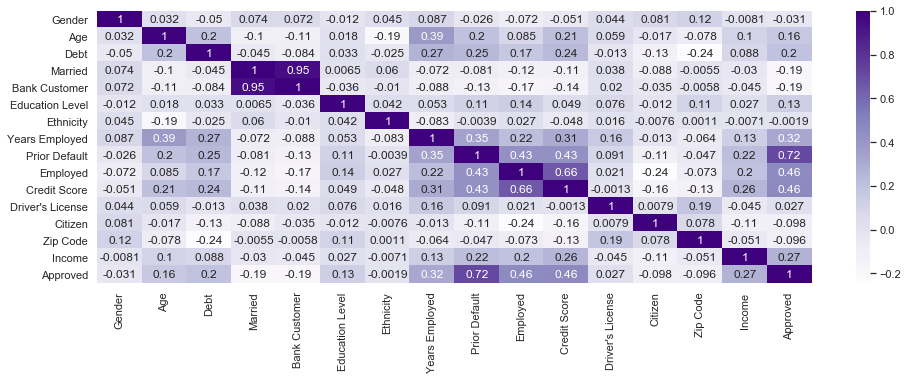

In [69]:
# matrix for correlation between numeric variables 
fig, ax = plt.subplots(figsize=(16,5))
correlation = cc_df_clean.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True, ax=ax, cmap="Purples");

In [70]:
numeric_cols = ['Age', 'Debt', 'Years Employed', 
               'Credit Score', 'Zip Code', 
                'Income', 'Approved', 'Prior Default']

In [71]:
# create filtered version of DataFrame 
# only has numeric columns
numeric_df_clean = cc_df_clean[numeric_cols]
numeric_df_clean.head()

,Age,Debt,Years Employed,Credit Score,Zip Code,Income,Approved,Prior Default
0,30.83,0.000,1.25,1,202.0,0,1,1
1,58.67,4.460,3.04,6,43.0,560,1,1
2,24.50,0.500,1.50,0,280.0,824,1,1
3,27.83,1.540,3.75,5,100.0,3,1,1
4,20.17,5.625,1.71,0,120.0,0,1,1


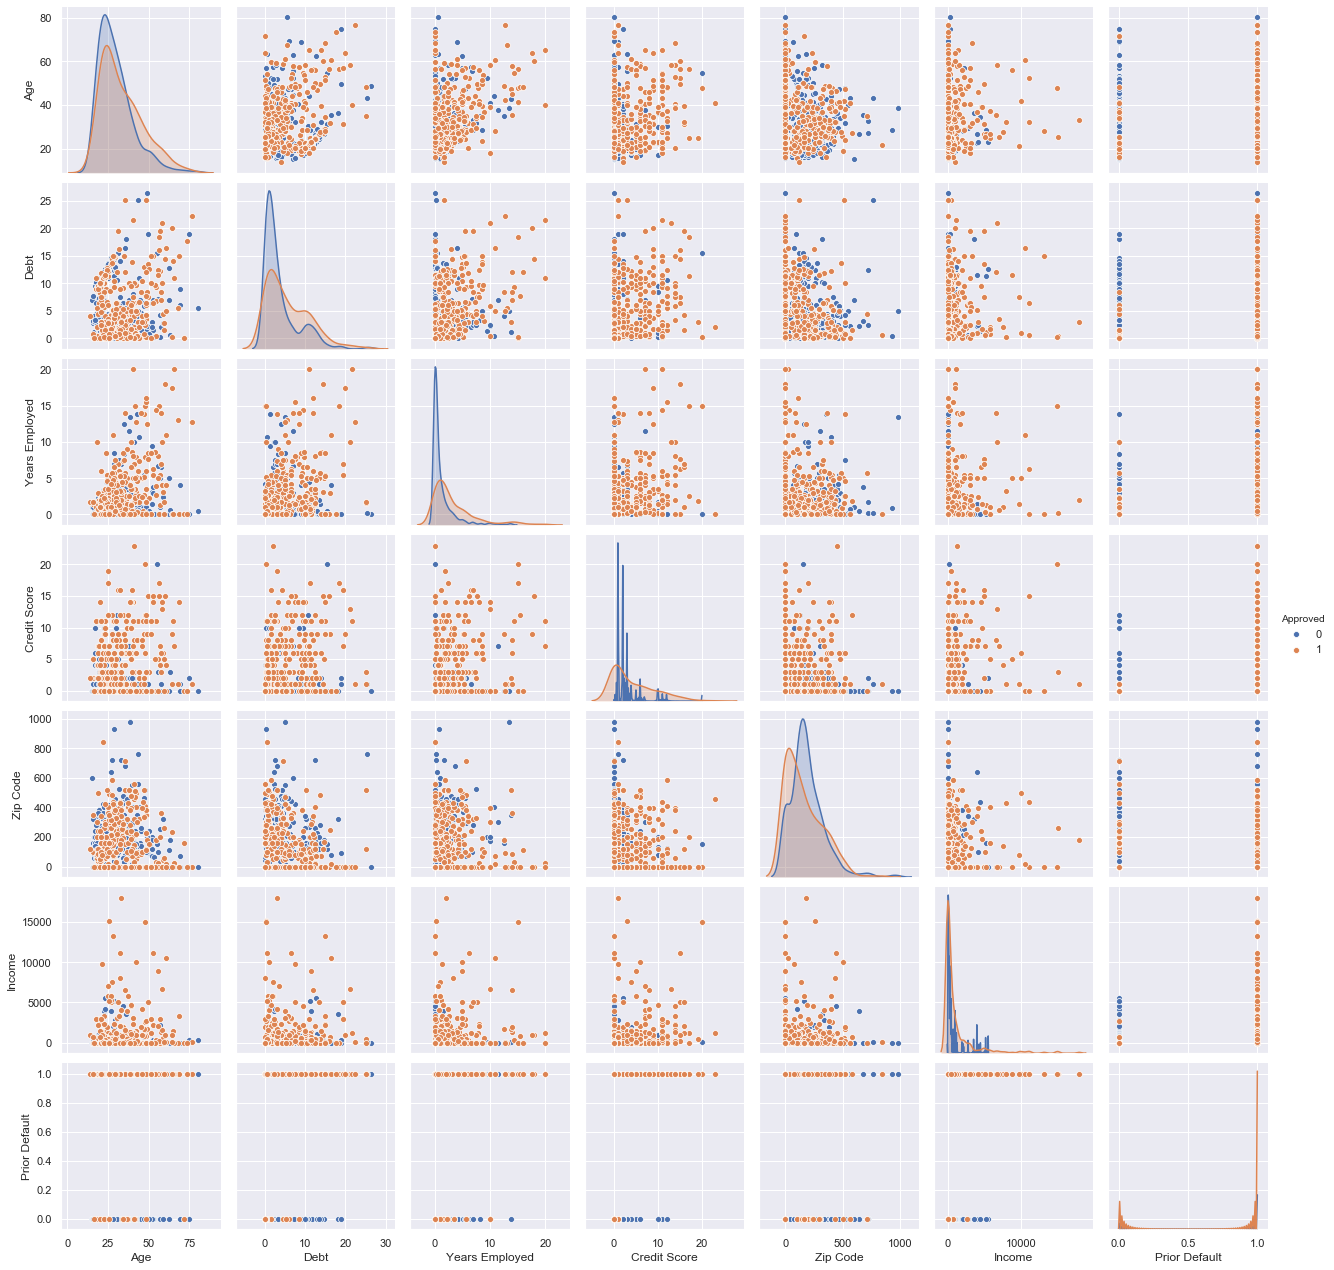

In [72]:
# create pairplots of all numeric factors in the dataset 
# hue is based on approval status 
sns.pairplot(numeric_df_clean, hue="Approved")

In [73]:
numeric_cols = ['Age', 'Debt', 'Years Employed', 
               'Credit Score', 'Zip Code', 
                'Income', 'Prior Default']

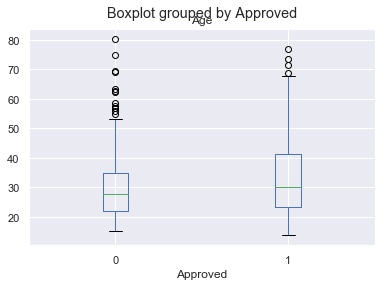

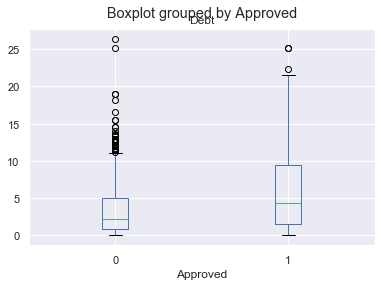

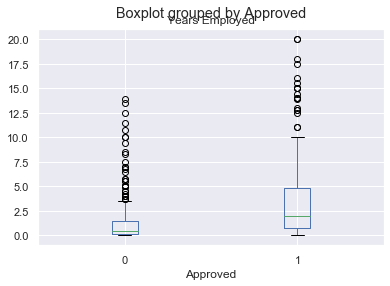

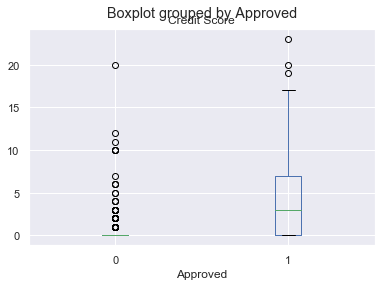

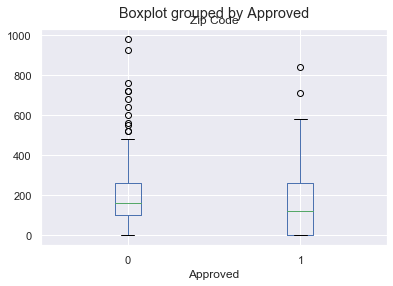

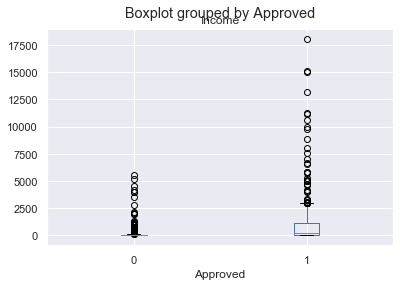

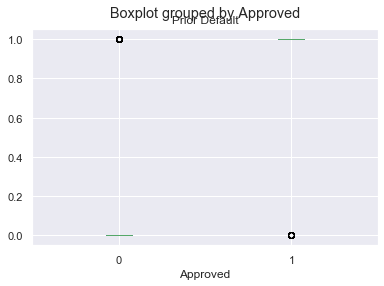

In [74]:
# create boxplots for each numeric attribute
# grouped by approval status 
for i in numeric_cols:
    numeric_df_clean.boxplot(column=i, by='Approved')

## Proposed Models:
## Parametric and Structured Models:
* **Linear Regression:** Code 1 for approved and 0 for not approved. Then simply perform a linear regression of Y(approved) on X and classify as yes if the predicted Y is greater than 0.5. Since this dataset has a binary outcome, linear regression might do well as a classifier. The scatterplots of attributes show a good amount of noise so a linear model might do well since it would be hard to discern another shape for the model. <br> Of the predictors in the dataset, only Prior Default has a correlation coefficient above 0.7 with approval status so the relationship between approval status and the other predictors on their own may be hard to model with a linear model. Moreover, there may be synergy between the variables. As a classifier, linear regression can produce probablities less than zero or greater than one so I am testing the linear model knowing that logistic regression is more appropriate.   

* **Multiple Linear Regression**: Some predictors may have greater effects than others and analysis of the βi terms will identify factors with more or less importance. The ideal scenario for this model is when predictors are uncorrelated. I will have to see whether the correlations between predictors in the dataset will make it difficult to interpret the regression coefficients. Since I have 15 predictors, I plan to use stepwise selection instead of best attribute subset selection. Computationally stepwise selection is better than considering 2^15 possible models and helps avoid overfitting and high variance.  

* **Logistic Regression**: Very popular for binary classification. Unlike linear regression, logistic regression will only produce values between 0 and 1. In addition to the predictions, it will be possible to see the probability of a particular classification. It is better for the input variables to have a Gaussian distribution so transforming the data can result in a more accurate model. I need to make sure that I handled the transformation process effectively. Correlation betweeen variables could also be an issue here. I plan to use GridSearching to see if I can make the model perform better by hypertuning the parameters. 

## Flexible Models:
* **LDA**: uses Bayes’ theorem for classification. LDA assumes that observations from each class/category come from a normal distribution with a class-specific mean vector and common variance. The method uses a Bayes’ estimator to fit the observed data to these model parameters. It generally performs better than Logistic regression when there are more than 3 classes/ categories. I only have a binary classification, but LDA is useful when n is small or the classes are well separated and Gaussian assumptions are reasonable. In this case, I have a small n under 1000 so LDA could be useful. From the scatterplots in this EDA, it looks like there are some features that might separate the classes. Logistic regression becomes unstable if classes are well separated so that will be of interest to explore and compare logistic regression to LDA. In the EDA, we saw that the predictors are not normally distributed so transformation would be important here as well. 

* **Naive Bayes Classifier**: classifies to highest density. Makes an assumption of class independence that doesn't actually hold for the variables in this dataset. It can perform well even conditional independence assumptions don't hold in the real world so I am interested in its performance on this dataset. Can be used for mixed feature vectors of qualitative and quantitative variables like the ones in this dataset. Can be useful for very large p. A p of 15 isn't exceptionally large, but this model still might help with the number of dimensions. 

* **KNN**: Nearest neighbor averaging can be pretty good for small p (i.e. p<= 4) and large-is N. Nearest neighbor methods can be lousy when p is large due to the curse of dimensionality. Nearest neighbors tend to be far away in high dimensions. For this dataset, p = 15 and n is relatively small at less than a 1000 so I am anticipating that a flexible model won't provide the best fit. 

Typically as the flexibility of a model increases, its variance increases, and its bias decreases. Choosing flexibility based on average test error amounts to a bias-variance trade-off. It will be interesting to see how that trade-off comes into play with the models in this project given the small n and larger p. 

## Models, Results and Analysis

## Parametric and Structured Models

## Linear Regression

+ **Why is this appropriate for a classification task?** Since this dataset has a binary outcome, linear regression might do well as a classifier. Code 1 for approved and 0 for not approved. Then simply perform a linear regression of Y(approved) on X and classify as yes if the predicted Y is greater than a threshold of 0.5. 

+ As a classifier, linear regression can produce probablities less than zero or greater than one so I am testing the linear model knowing that logistic regression is more appropriate. 

## Simple Linear Regression


**Some of my initial thoughts about a simple linear model**: Of the predictors in the dataset, only Prior Default has a correlation coefficient above 0.7 with approval status so the relationship between approval status and the other predictors on their own may be hard to model with a linear model. Moreover, there may be synergy between the variables that can't be captured with a simple model like this. 

In [75]:
# predictors in the dataset 
predictors = ['Gender', 'Age','Debt','Married', 'Customer', 
          'Education', 'Ethnicity', 'Years_Employed',
          'Prior_Default', 'Employed', 'Credit_Score',
          'Driver_License', 'Citizen','Zip_Code', 
          'Income']

In [76]:
# create dataframe with the training set
# use the rescaled version of the data 
# using rescaled version not as important for regression
# as techniques like K-Nearest Neighbors
# if there are predictor variables with large ranges that do not effect the target variable, 
# a regression algorithm will make the corresponding coefficients small 
# so that they do not effect predictions so much
x_df_train = pd.DataFrame(data=rescaledX_train, columns=predictors)
print(x_df_train.head())

   Gender       Age      Debt   Married  Customer  Education  Ethnicity  \
0     1.0  0.125263  0.031517  0.666667  0.333333   0.142857   0.444444   
1     0.0  0.205564  0.550598  0.666667  0.333333   1.000000   0.444444   
2     0.0  0.659098  0.075945  0.666667  0.333333   0.428571   0.333333   
3     1.0  0.065113  0.208848  0.666667  0.333333   0.642857   0.888889   
4     0.0  0.134135  0.012721  0.666667  0.333333   0.785714   0.888889   

   Years_Employed  Prior_Default  Employed  Credit_Score  Driver_License  \
0         0.10825            0.0       0.0          0.00             1.0   
1         0.15425            1.0       1.0          0.05             0.0   
2         0.32500            0.0       1.0          0.05             0.0   
3         0.02500            1.0       0.0          0.00             0.0   
4         0.03750            0.0       0.0          0.00             0.0   

   Citizen  Zip_Code    Income  
0      0.0  0.168421  0.000000  
1      0.0  0.157895  0.00

In [77]:
# training series with approval status
y_df_train = pd.DataFrame(data=y_train, columns=['Approved']) 
print(y_df_train.head())

   Approved
0       1.0
1       1.0
2       0.0
3       1.0
4       0.0


In [78]:
# concatenate x and y together to create dataframe of training set
train_df = pd.concat([x_df_train, y_df_train], axis=1, sort=False)
print(train_df.head())

   Gender       Age      Debt   Married  Customer  Education  Ethnicity  \
0     1.0  0.125263  0.031517  0.666667  0.333333   0.142857   0.444444   
1     0.0  0.205564  0.550598  0.666667  0.333333   1.000000   0.444444   
2     0.0  0.659098  0.075945  0.666667  0.333333   0.428571   0.333333   
3     1.0  0.065113  0.208848  0.666667  0.333333   0.642857   0.888889   
4     0.0  0.134135  0.012721  0.666667  0.333333   0.785714   0.888889   

   Years_Employed  Prior_Default  Employed  Credit_Score  Driver_License  \
0         0.10825            0.0       0.0          0.00             1.0   
1         0.15425            1.0       1.0          0.05             0.0   
2         0.32500            0.0       1.0          0.05             0.0   
3         0.02500            1.0       0.0          0.00             0.0   
4         0.03750            0.0       0.0          0.00             0.0   

   Citizen  Zip_Code    Income  Approved  
0      0.0  0.168421  0.000000       1.0  
1     

In [79]:
# repeat steps above to create test dataframe with x and y 
x_df_test = pd.DataFrame(data=rescaledX_test, columns=predictors)
print(x_df_test.head())

   Gender       Age      Debt   Married  Customer  Education  Ethnicity  \
0     0.0  0.385677  0.066269  0.666667  0.333333   0.000000   0.888889   
1     1.0  0.133972  0.039801  0.666667  0.333333   0.142857   0.888889   
2     0.0  0.338259  0.039801  0.666667  0.333333   0.142857   0.888889   
3     1.0  0.319259  0.099502  1.000000  1.000000   0.928571   0.888889   
4     1.0  0.205586  0.159204  1.000000  1.000000   0.500000   0.444444   

   Years_Employed  Prior_Default  Employed  Credit_Score  Driver_License  \
0          0.0125            0.0       0.0      0.000000             0.0   
1          0.0250            0.0       0.0      0.000000             1.0   
2          0.1000            1.0       1.0      0.478261             0.0   
3          0.1500            0.0       0.0      0.000000             0.0   
4          0.2875            1.0       1.0      0.086957             1.0   

   Citizen  Zip_Code    Income  
0      0.0  0.000000  0.034815  
1      1.0  0.285714  0.00

In [80]:
y_df_test = pd.DataFrame(data=y_test, columns=['Approved']) 
print(y_df_test.head())

   Approved
0       0.0
1       0.0
2       1.0
3       0.0
4       0.0


In [81]:
test_df = pd.concat([x_df_test, y_df_test], axis=1, sort=False)
print(test_df.head())

   Gender       Age      Debt   Married  Customer  Education  Ethnicity  \
0     0.0  0.385677  0.066269  0.666667  0.333333   0.000000   0.888889   
1     1.0  0.133972  0.039801  0.666667  0.333333   0.142857   0.888889   
2     0.0  0.338259  0.039801  0.666667  0.333333   0.142857   0.888889   
3     1.0  0.319259  0.099502  1.000000  1.000000   0.928571   0.888889   
4     1.0  0.205586  0.159204  1.000000  1.000000   0.500000   0.444444   

   Years_Employed  Prior_Default  Employed  Credit_Score  Driver_License  \
0          0.0125            0.0       0.0      0.000000             0.0   
1          0.0250            0.0       0.0      0.000000             1.0   
2          0.1000            1.0       1.0      0.478261             0.0   
3          0.1500            0.0       0.0      0.000000             0.0   
4          0.2875            1.0       1.0      0.086957             1.0   

   Citizen  Zip_Code    Income  Approved  
0      0.0  0.000000  0.034815       0.0  
1     

In [82]:
# use Statsmodel to create simple linear regression model of Approved based on a single predictor 
# train model on the training set 
for i in predictors:
    model = smf.ols(formula=f'Approved~{i}', data=train_df).fit()
    print(f"Dependent variable: {i}")
    print(model.summary())
    print(model.params[0])
    print(model.params[1])

Dependent variable: Gender
                            OLS Regression Results                            
Dep. Variable:               Approved   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.04322
Date:                Mon, 04 May 2020   Prob (F-statistic):              0.835
Time:                        07:07:37   Log-Likelihood:                -328.40
No. Observations:                 456   AIC:                             660.8
Df Residuals:                     454   BIC:                             669.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4545    

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
0.44925367961366913
-0.002807366159107365
Dependent variable: Years_Employed
                            OLS Regression Results                            
Dep. Variable:               Approved   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     64.92
Date:                Mon, 04 May 2020   Prob (F-statistic):           6.96e-15
Time:                        07:07:38   Log-Likelihood:                -297.95
No. Observations:                 456   AIC:                             599.9
Df Residuals:                     454   BIC:                             608.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err     

## Results and Analysis for Simple Linear Regression

If the focus of this project was on regression, then we would want to pay close attention to **R-squared** as a meeasure of how well the model fits the data. The R-Squared value is a measure of how much variance in the data is explained by that particular model. R-squared values closer to 1 indicate a better fit. In this case, the highest R-squared value is 0.535 for the model with the Prior Default predictor. The large T value of 22.847 and low p-value of 0.000 support the Prior Default coefficient not being equal to 0. This is further supported by the confidence interval for the Prior Default coefficient not overlapping zero.<br>
Since this is a classification task, I will focus my attention on evaluation metrics for classifiers. 

### Evaluating Regression: Diagnostic Plots
The model predicting Approved based on Prior-Default had the highest R-Squared value of 0.535 for a single predictor. This R-squared value wasn't even ultimately that close to one. Another diagnostic for regression is that the **residuals** are supposed to be normally distributed- if they are not, it will likely introduce errors in your model that are not clear from measurements such as R-Squared. . I checked the residuals against the theoretical quantiles of the normal distribution for the model with the Prior Default predictor. The line is not linear and diagonal as would be expected if the residuals were normally distributed so this model might not actually be a good fit. 

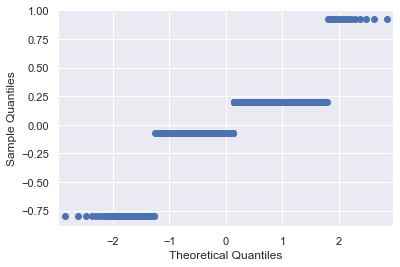

In [83]:
prior_default_model = smf.ols(formula=f'Approved~ Prior_Default', data=train_df).fit()
sm.qqplot(prior_default_model.resid);

In [84]:
# create a heatmap from a confusion matrix
# rows in the heatmap have the actual label
# columns in the heatmap have the predicted label 
def heatmap(confusion_matrix): 
    # use 1 for Approved, 0 for Denied
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap from the sklearn gneerated consuion matrix
    sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [85]:
# function creates a simple linear regression model with a single predictor
def simple_linear_regression(i, train_df, test_df):
    # trains model on the training set 
    # ols stands for Ordinary Least Squares 
    # ols is the most common estimation method for linear models 
    model = smf.ols(formula=f'Approved~{i}', data=train_df).fit()
    df = test_df[[i, 'Approved']]
    df = df.copy()
    
    # makes predictions on the test set using the parameters from the model
    df['y_hat'] = (model.params[0] + model.params[1]*df[i])
    print(f"{model.params[0]}, {model.params[1]}")
    # use a threshold of greater than or equal to 0.5 for approved
    # otherwsie denied
    df.loc[:,'Prediction'] = np.where(df['y_hat'] >= 0.5, 1.0, 0.0)
    print(df.head())
    
    # use seaborn to create a scatterplot 
    # least squares estimation line with shading for 99% confidence interval
    # dashed line at 0.5 to show decision threshold
    sns.regplot(x=i, y = "Approved", data=train_df, ci=99);
    plt.axhline(0.5, ls='--')         

    # print sklearn classification report with evaluation metrics
    # including acuracy, precision, recall and f1-score 
    print(f"Evaluation Metrics for Variable {i}")
    print(classification_report(df['Approved'], df['Prediction'], zero_division=0))
    
    # generate heatmap from confusion matrix 
    # rows have actual values
    # columns have predicted values 
    confusion_matrix = metrics.confusion_matrix(df['Approved'], df['Prediction'])
    heatmap(confusion_matrix)

0.4545454545454545, -0.010455997676445105
   Gender  Approved     y_hat  Prediction
0     0.0       0.0  0.454545         0.0
1     1.0       0.0  0.444089         0.0
2     0.0       1.0  0.454545         0.0
3     1.0       0.0  0.444089         0.0
4     1.0       0.0  0.444089         0.0
Evaluation Metrics for Variable Gender
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       129
         1.0       0.00      0.00      0.00        96

    accuracy                           0.57       225
   macro avg       0.29      0.50      0.36       225
weighted avg       0.33      0.57      0.42       225



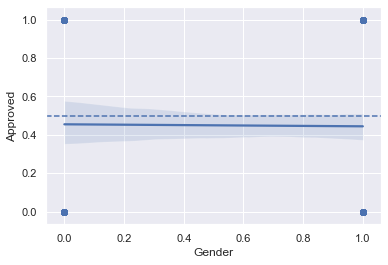

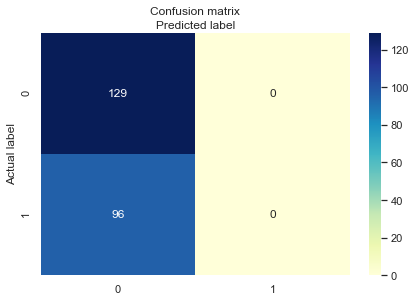

0.32872538581002275, 0.4414697697874792
        Age  Approved     y_hat  Prediction
0  0.385677       0.0  0.498990         0.0
1  0.133972       0.0  0.387870         0.0
2  0.338259       1.0  0.478057         0.0
3  0.319259       0.0  0.469669         0.0
4  0.205586       0.0  0.419485         0.0
Evaluation Metrics for Variable Age
              precision    recall  f1-score   support

         0.0       0.63      0.86      0.73       129
         1.0       0.62      0.31      0.42        96

    accuracy                           0.63       225
   macro avg       0.63      0.59      0.57       225
weighted avg       0.63      0.63      0.59       225



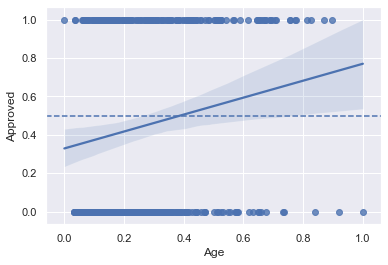

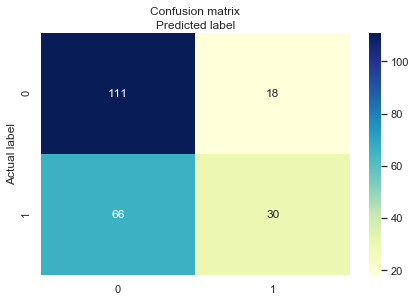

0.3554198280690348, 0.5076460718066378
       Debt  Approved     y_hat  Prediction
0  0.066269       0.0  0.389061         0.0
1  0.039801       0.0  0.375625         0.0
2  0.039801       1.0  0.375625         0.0
3  0.099502       0.0  0.405932         0.0
4  0.159204       0.0  0.436239         0.0
Evaluation Metrics for Variable Debt
              precision    recall  f1-score   support

         0.0       0.62      0.82      0.71       129
         1.0       0.58      0.33      0.42        96

    accuracy                           0.61       225
   macro avg       0.60      0.58      0.57       225
weighted avg       0.61      0.61      0.59       225



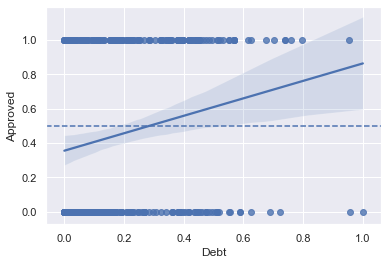

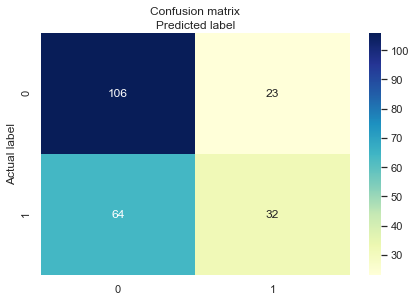

0.9224460910831739, -0.6384147864457592
    Married  Approved     y_hat  Prediction
0  0.666667       0.0  0.496836         0.0
1  0.666667       0.0  0.496836         0.0
2  0.666667       1.0  0.496836         0.0
3  1.000000       0.0  0.284031         0.0
4  1.000000       0.0  0.284031         0.0
Evaluation Metrics for Variable Married
              precision    recall  f1-score   support

         0.0       0.58      0.99      0.73       129
         1.0       0.67      0.02      0.04        96

    accuracy                           0.58       225
   macro avg       0.62      0.51      0.38       225
weighted avg       0.62      0.58      0.44       225



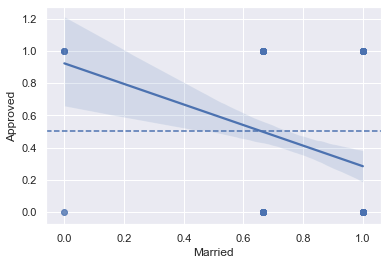

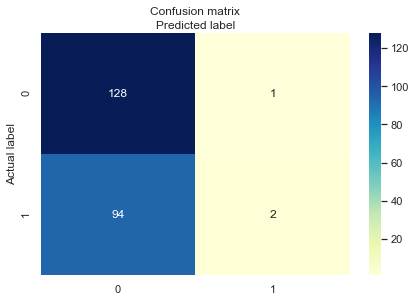

0.6229697212753162, -0.3532684980950473
   Customer  Approved     y_hat  Prediction
0  0.333333       0.0  0.505214         1.0
1  0.333333       0.0  0.505214         1.0
2  0.333333       1.0  0.505214         1.0
3  1.000000       0.0  0.269701         0.0
4  1.000000       0.0  0.269701         0.0
Evaluation Metrics for Variable Customer
              precision    recall  f1-score   support

         0.0       0.71      0.26      0.38       129
         1.0       0.46      0.85      0.60        96

    accuracy                           0.52       225
   macro avg       0.59      0.56      0.49       225
weighted avg       0.60      0.52      0.48       225



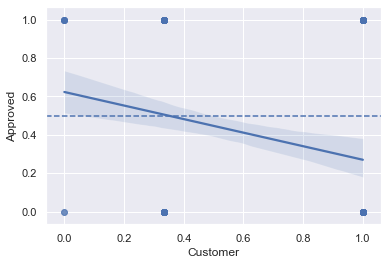

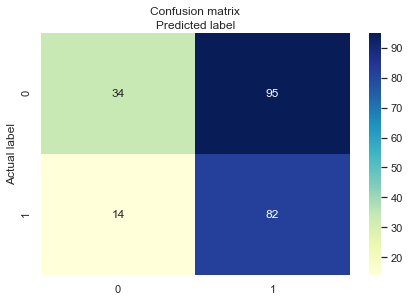

0.33426090147391563, 0.23597333496422251
   Education  Approved     y_hat  Prediction
0   0.000000       0.0  0.334261         0.0
1   0.142857       0.0  0.367971         0.0
2   0.142857       1.0  0.367971         0.0
3   0.928571       0.0  0.553379         1.0
4   0.500000       0.0  0.452248         0.0
Evaluation Metrics for Variable Education
              precision    recall  f1-score   support

         0.0       0.64      0.76      0.69       129
         1.0       0.56      0.42      0.48        96

    accuracy                           0.61       225
   macro avg       0.60      0.59      0.59       225
weighted avg       0.61      0.61      0.60       225



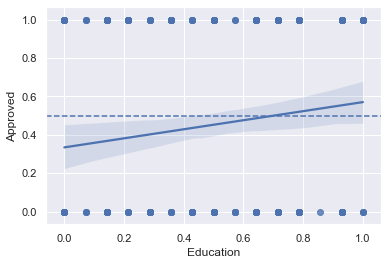

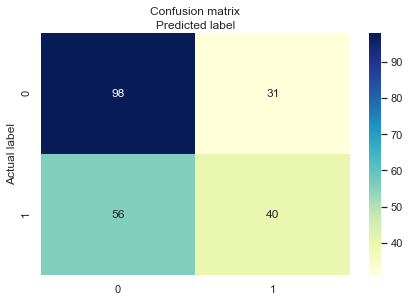

0.44925367961366913, -0.002807366159107365
   Ethnicity  Approved     y_hat  Prediction
0   0.888889       0.0  0.446758         0.0
1   0.888889       0.0  0.446758         0.0
2   0.888889       1.0  0.446758         0.0
3   0.888889       0.0  0.446758         0.0
4   0.444444       0.0  0.448006         0.0
Evaluation Metrics for Variable Ethnicity
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       129
         1.0       0.00      0.00      0.00        96

    accuracy                           0.57       225
   macro avg       0.29      0.50      0.36       225
weighted avg       0.33      0.57      0.42       225



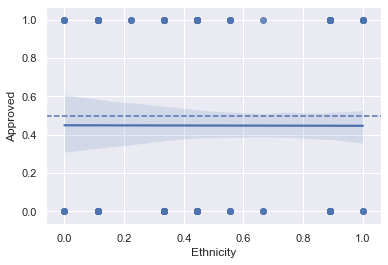

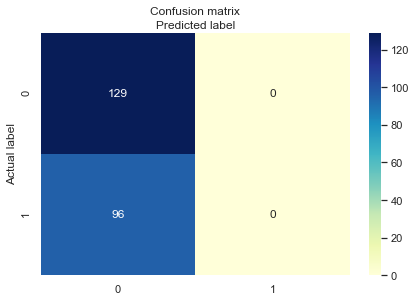

0.32908051924615245, 1.0807797030271726
   Years_Employed  Approved     y_hat  Prediction
0          0.0125       0.0  0.342590         0.0
1          0.0250       0.0  0.356100         0.0
2          0.1000       1.0  0.437158         0.0
3          0.1500       0.0  0.491197         0.0
4          0.2875       0.0  0.639805         1.0
Evaluation Metrics for Variable Years_Employed
              precision    recall  f1-score   support

         0.0       0.65      0.88      0.74       129
         1.0       0.68      0.35      0.47        96

    accuracy                           0.65       225
   macro avg       0.66      0.62      0.60       225
weighted avg       0.66      0.65      0.62       225



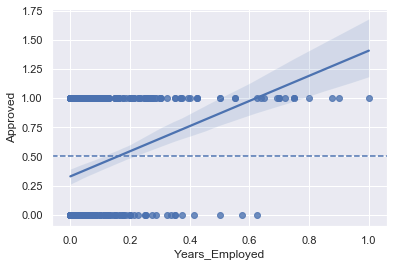

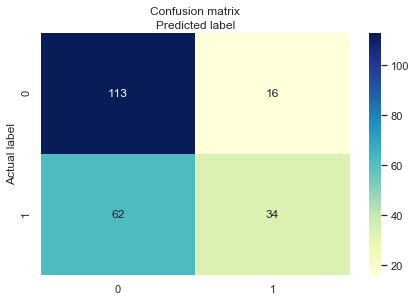

0.07239819004524867, 0.7276018099547517
   Prior_Default  Approved     y_hat  Prediction
0            0.0       0.0  0.072398         0.0
1            0.0       0.0  0.072398         0.0
2            1.0       1.0  0.800000         1.0
3            0.0       0.0  0.072398         0.0
4            1.0       0.0  0.800000         1.0
Evaluation Metrics for Variable Prior_Default
              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85       129
         1.0       0.75      0.94      0.83        96

    accuracy                           0.84       225
   macro avg       0.85      0.85      0.84       225
weighted avg       0.86      0.84      0.84       225



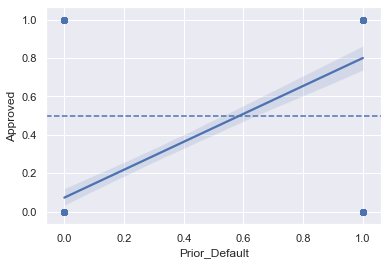

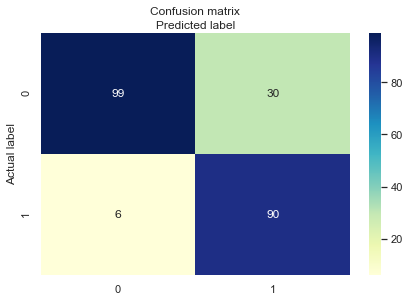

0.2547528517110265, 0.45509170787446573
   Employed  Approved     y_hat  Prediction
0       0.0       0.0  0.254753         0.0
1       0.0       0.0  0.254753         0.0
2       1.0       1.0  0.709845         1.0
3       0.0       0.0  0.254753         0.0
4       1.0       0.0  0.709845         1.0
Evaluation Metrics for Variable Employed
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78       129
         1.0       0.70      0.70      0.70        96

    accuracy                           0.74       225
   macro avg       0.74      0.74      0.74       225
weighted avg       0.74      0.74      0.74       225



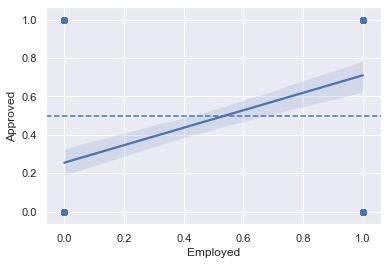

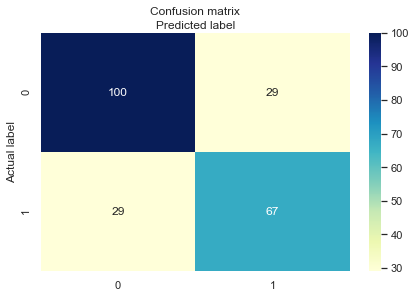

0.3198418233343265, 1.0839166553503627
   Credit_Score  Approved     y_hat  Prediction
0      0.000000       0.0  0.319842         0.0
1      0.000000       0.0  0.319842         0.0
2      0.478261       1.0  0.838237         1.0
3      0.000000       0.0  0.319842         0.0
4      0.086957       0.0  0.414095         0.0
Evaluation Metrics for Variable Credit_Score
              precision    recall  f1-score   support

         0.0       0.70      0.99      0.82       129
         1.0       0.98      0.43      0.59        96

    accuracy                           0.75       225
   macro avg       0.84      0.71      0.71       225
weighted avg       0.82      0.75      0.72       225



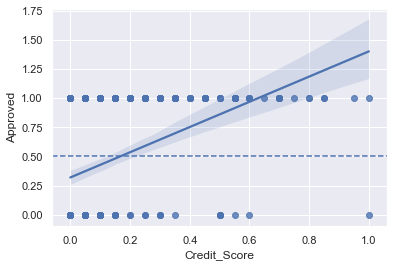

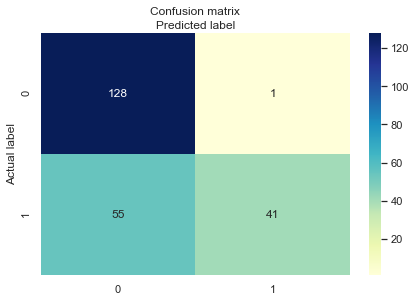

0.4297188755020079, 0.038880158314416956
   Driver_License  Approved     y_hat  Prediction
0             0.0       0.0  0.429719         0.0
1             1.0       0.0  0.468599         0.0
2             0.0       1.0  0.429719         0.0
3             0.0       0.0  0.429719         0.0
4             1.0       0.0  0.468599         0.0
Evaluation Metrics for Variable Driver_License
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       129
         1.0       0.00      0.00      0.00        96

    accuracy                           0.57       225
   macro avg       0.29      0.50      0.36       225
weighted avg       0.33      0.57      0.42       225



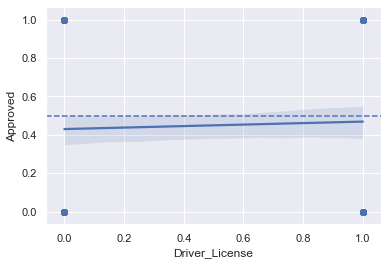

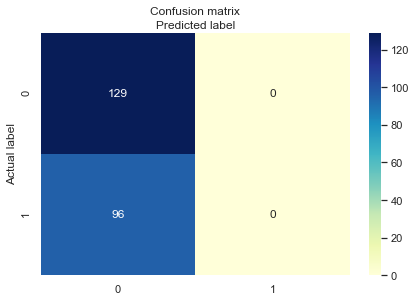

0.46385569958942574, -0.1856345435253954
   Citizen  Approved     y_hat  Prediction
0      0.0       0.0  0.463856         0.0
1      1.0       0.0  0.278221         0.0
2      0.0       1.0  0.463856         0.0
3      1.0       0.0  0.278221         0.0
4      0.0       0.0  0.463856         0.0
Evaluation Metrics for Variable Citizen
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       129
         1.0       0.00      0.00      0.00        96

    accuracy                           0.57       225
   macro avg       0.29      0.50      0.36       225
weighted avg       0.33      0.57      0.42       225



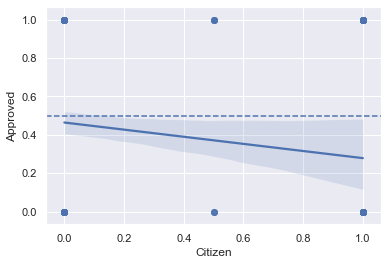

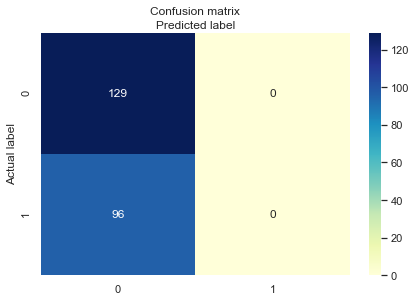

0.5012013503267299, -0.2430635133767388
   Zip_Code  Approved     y_hat  Prediction
0  0.000000       0.0  0.501201         1.0
1  0.285714       0.0  0.431755         0.0
2  0.000000       1.0  0.501201         1.0
3  0.204082       0.0  0.451597         0.0
4  0.076531       0.0  0.482600         0.0
Evaluation Metrics for Variable Zip_Code
              precision    recall  f1-score   support

         0.0       0.61      0.90      0.73       129
         1.0       0.63      0.23      0.34        96

    accuracy                           0.61       225
   macro avg       0.62      0.56      0.53       225
weighted avg       0.62      0.61      0.56       225



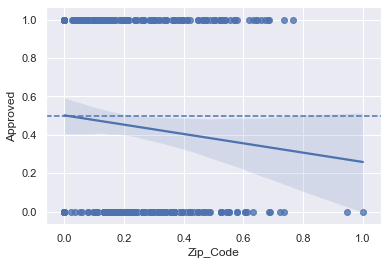

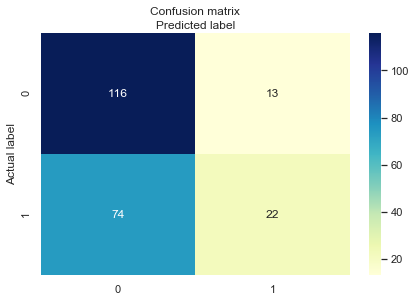

0.3969894319611074, 1.3607466906428125
     Income  Approved     y_hat  Prediction
0  0.034815       0.0  0.444364         0.0
1  0.000000       0.0  0.396989         0.0
2  0.040707       1.0  0.452381         0.0
3  0.000000       0.0  0.396989         0.0
4  0.000000       0.0  0.396989         0.0
Evaluation Metrics for Variable Income
              precision    recall  f1-score   support

         0.0       0.62      0.89      0.73       129
         1.0       0.64      0.26      0.37        96

    accuracy                           0.62       225
   macro avg       0.63      0.58      0.55       225
weighted avg       0.63      0.62      0.58       225



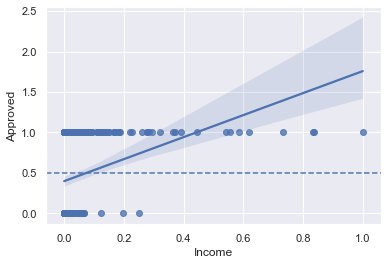

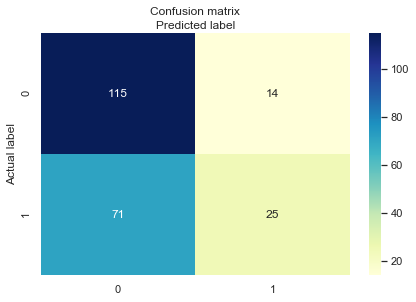

In [86]:
# run simple linear regression function on all predictors 
for i in predictors:
  simple_linear_regression(i, train_df, test_df)  

In [87]:
# reminder of the breakdown of approved vs denied
cc_df['Approved'].value_counts()

0    383
1    307
Name: Approved, dtype: int64

In [88]:
# the largest category is denied with a count of 383
# there are 690 data objects in the dataset 
print(383/690)

0.5550724637681159


## Results Summary for Simple Linear Regression
The approvals in this dataset are fairly blanced with about 55.5% of the applications denied and 44.5% of the applications approved. Even though it would be highly ineffective to never approve applicants, simply classifying all of the applications as denied would give a classifier with 55.5% accuracy. (That is for the entire dataset with a train/test split). Many of these linear models would not make effective classifiers. For instance, the **accuracy** of the model with Age is 63% which might sound alright on the surface (it is somewhat close to the accuracy from just denying everything). However, for the classifier to have any sort of functionality, it is important to also pay attention to the **precision** and **recall**. ***Precision*** refers to how exact the predictions are. In this case, 62% of predicted approvals were actually approved. ***Recall*** refers to completeness. In this case, the classifier only predicted that 31% of actual approvals would be approved. The numbers for these simple models show the limitations of relying on accuracy alone in assessing the performance of a classifier for this dataset. For the purposes of this project, one metric that we can consider is the **F1 score** that combines precision and recall into a single higher is better metric. In practice, different types of misclassifications incur different costs. Ultimately, a financial institution would need to decide whether precision and recall should have the same relative importance. 
<br>   

+ Predictors that performed poorly: Gender, Age, Debt, Married, Customer, Education, Ethnicity, Years Employed, Driver's License, Citizen, Zip Code 
+ Predictors of interest: Prior Default, Employed, Credit Score, and Income 
+ **Prior Default**: model had very strong performance. F1 score of 0.85 for Denied, 0.83 for Approved. 0.84 overall accuracy. 
+ **Employed**: also had strong performance. F1 score of 0.78 for Denied, 0.70 for Approved. 0.74 overall accuracy.
+ **Credit Score**: better performance on rejections than approvals. F1 score of 0.82 for Denied, 0.59 for Approved. Overall accuracy of 0.75.
+ **Income**: hypothesized that income was going to be an important predictor. The simple linear model with income as the predictor struggled to classify approvals. Overall accuracy was 0.62 with a F1 score of 0.73 for rejections and 0.37 for approvals.

### Further Exploration of Prior Default Model: ROC and AUC
Look at Prior Default Model in closer detail since it performed so well. 

In [89]:
default_df = test_df[['Prior_Default', 'Approved']]
default_df = default_df.copy()
    
# makes predictions on the test set using the parameters from the model
default_df['y_hat'] = (prior_default_model.params[0] + prior_default_model.params[1]*default_df['Prior_Default'])
    
# use a threshold of greater than or equal to 0.5 for approved
# otherwsie denied
default_df.loc[:,'Prediction'] = np.where(default_df['y_hat'] >= 0.5, 1.0, 0.0)
print(default_df.head())

   Prior_Default  Approved     y_hat  Prediction
0            0.0       0.0  0.072398         0.0
1            0.0       0.0  0.072398         0.0
2            1.0       1.0  0.800000         1.0
3            0.0       0.0  0.072398         0.0
4            1.0       0.0  0.800000         1.0


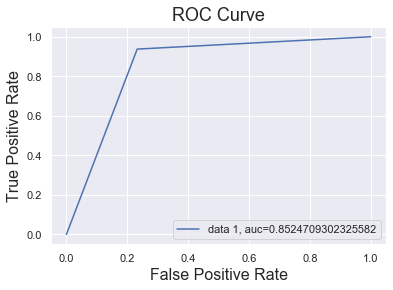

In [90]:
# code for ROC Curve Plot
fpr, tpr, _ = metrics.roc_curve(default_df['Approved'],  default_df['y_hat'])
auc = metrics.roc_auc_score(default_df['Approved'], default_df['y_hat'])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()

It is ideal for a ROC Curve to be high up in the left corner with a high True Positive Rate when the False Positive Rate is 0. The **ROC Curve** traces out how the false positive rate and true positive rate change as we change the threshold. The top of the curve is relatively close to the top left corner for this model. Sometimes we also use the **AUC(Area Under the Curve)** to summarize overall performance. Higher is better. In this case, AUC is also pretty high at 0.85. The ROC Curve is helpful for capturing the behvaior of a classifier over multiple thresholds.  

## Multiple Linear Regression
Now that I've tried a simple linear regression model, I'm going to extend the linear model and consider **multilinear regression**. Where simple linear regression creates a line, multilinear regression creates a hyperplane. Some predictors may have greater effects than others and analysis of the βi terms will identify factors with more or less importance. The ideal scenario for this model is when predictors are uncorrelated. In the EDA, I saw there are correlations between predictors so I am going to need to consider **collinearity** when developing this type of model. 

In [91]:
def list_to_string(predictor_array):
    # turns list of predictors into string with plus signs
    # that can be entered as model formula
    listToStr = '+'.join(map(str, predictor_array))
    print(listToStr)
    return listToStr

In [92]:
# to start, create a multilinear model that includes all predictors 
# finds coefficients that reduce the sum of least squares 
multilinear_model = smf.ols(formula='Approved ~ {}'.format(list_to_string(predictors)), data=train_df).fit()
print(multilinear_model.summary())

Gender+Age+Debt+Married+Customer+Education+Ethnicity+Years_Employed+Prior_Default+Employed+Credit_Score+Driver_License+Citizen+Zip_Code+Income
                            OLS Regression Results                            
Dep. Variable:               Approved   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     44.99
Date:                Mon, 04 May 2020   Prob (F-statistic):           5.79e-79
Time:                        07:07:51   Log-Likelihood:                -116.44
No. Observations:                 456   AIC:                             264.9
Df Residuals:                     440   BIC:                             330.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.

+ The R-squared value of 0.605 is higher than any of the linear models with a single predictor. The larger number of predictors mean that more variance is explained. 
+ The summary above shows that in the presence of the other variables in the model, the **following variables are not important**: Gender, Age, Debt, Education, Ethnicity, Credit Score, Driver's License, Citizen and Zip Code. These variables have low T-values and p-values higher than the significance level of 0.05. Moreover, their confidence intervals overlap zero so there is not evidence to reject the null hypothesis that they are equal to zero.
+ In the presence of the other variables in the model, the **following variables are important**: Married, Customer, Years Employed, Prior Default, Employed and Income. These variables have high T-values, low p-values below the significance level of 0.05. Their confidence intervals also don't overlap zero. There is evidence against the null hypothesis that they are not statistically significant. 

In [93]:
# returns prediction using coefficients from the multilinear model
def multilinear_regression_formula(predictors,params, df):
    y_hat = params[0]
    c = 1
    for i in predictors:
        y_hat += params[c]*df[i]
    return y_hat

In [94]:
# set up test DataFrame
multi_df = test_df
multi_df = multi_df.copy()

# use parameters from the multilinear model 
# to make approval predictions on the test set 
multilinear_params = multilinear_model.params
print(multilinear_params)

# store the prediction probabilities in y_hat column of test DataFrame
multi_df['y_hat'] = multilinear_regression_formula(predictors, multilinear_params, multi_df)

# probabilities above or equal to a threshold. of 0.5 classiied as approved
# otherwise denied
multi_df.loc[:,'Prediction'] = np.where(multi_df['y_hat'] >= 0.5, 1.0, 0.0)
print(multi_df.head(n=3))

Intercept         0.803978
Gender            0.016567
Age              -0.058871
Debt             -0.077051
Married          -1.463216
Customer          0.591548
Education         0.082370
Ethnicity         0.080077
Years_Employed    0.258671
Prior_Default     0.614698
Employed          0.095599
Credit_Score      0.121173
Driver_License   -0.038591
Citizen          -0.036937
Zip_Code         -0.145820
Income            0.449199
dtype: float64
   Gender       Age      Debt   Married  Customer  Education  Ethnicity  \
0     0.0  0.385677  0.066269  0.666667  0.333333   0.000000   0.888889   
1     1.0  0.133972  0.039801  0.666667  0.333333   0.142857   0.888889   
2     0.0  0.338259  0.039801  0.666667  0.333333   0.142857   0.888889   

   Years_Employed  Prior_Default  Employed  Credit_Score  Driver_License  \
0          0.0125            0.0       0.0      0.000000             0.0   
1          0.0250            0.0       0.0      0.000000             1.0   
2          0.1000       

## Results and Analysis for Multiple Linear Regression

In [95]:
def accuracy_metrics(df):
    # print sklearn classification report with evaluation metrics
    # including acuracy, precision, recall and f1-score 
    print(f"Evaluation Metrics for Multilinear Model")
    print(classification_report(df['Approved'], df['Prediction'], zero_division=0))

    # turns sklearn confusion matrix into a heatmap
    # actual values are rows
    # predicted values are columns 
    confusion_matrix = metrics.confusion_matrix(df['Approved'], df['Prediction'])
    heatmap(confusion_matrix)

Evaluation Metrics for Multilinear Model
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       129
         1.0       0.43      1.00      0.60        96

    accuracy                           0.43       225
   macro avg       0.21      0.50      0.30       225
weighted avg       0.18      0.43      0.26       225



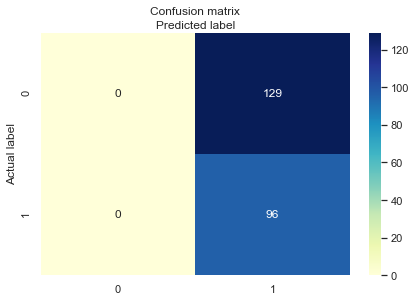

In [96]:
# run accuracy metrics function on model
accuracy_metrics(multi_df)

In [97]:
# verify that this occurs because all predictions are 1 
print(multi_df['Prediction'].unique())

[1.]


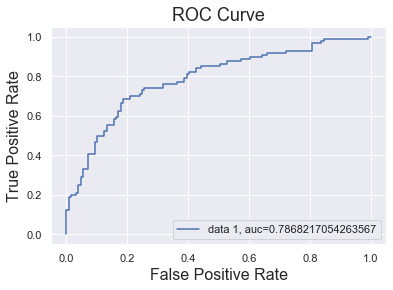

In [98]:
# code for ROC Curve Plot
fpr, tpr, _ = metrics.roc_curve(multi_df['Approved'],  multi_df['y_hat'])
auc = metrics.roc_auc_score(multi_df['Approved'], multi_df['y_hat'])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()

In [99]:
# reminder of the breakdown of approved vs denied
multi_df['Approved'].value_counts()

0.0    129
1.0     96
Name: Approved, dtype: int64

In [100]:
print(129/len(multi_df))

0.5733333333333334


As a classifier, this multilinear model performed very poorly. The intercept has a value of 0.8039 so even though there are some negative coefficient values, the probability doesn't fall below the threshold of 0.5. On this test set, all predicted values were approved which would be highly questionable for a financial institution. The Denied class has a F1 score of 0. The Approved class has an F1 score of 0.60. The overall model has an accuracy of 0.43. For the purposes of accuracy, it would have been much more advantageous to deny everyone and achieve an accuracy of 0.57 on the test set. The ROC Curve visually supports the model not being accurate because it doesn't extend into the upper left corner. 

## Collinearity 
**Collinearity** is a condition or phenomenon specifically in regression models where some of the predictor variables (independent) are highly correlated. The correlation matrix lends support to some quantitative attributes being correlated because the correlation matrix shows some correlation coefficients close to 1 for predictors. Collinearity refers to the situation where two or more predictor variables are closely related to one another. For the pairplot, it looks like some of the attributes have colinearity. A Wikipedia article on collinarity indicates, "correlation values (off-diagonal elements) of at least 0.4 are sometims interpreted as indicating a multicollienarity problem." https://en.wikipedia.org/wiki/Multicollinearity 
Some of the off-diagonal correlation coefficient values for predictors:

+ Credit Score with Employed: 0.66
+ Prior Default with Employed and Credit Score: 0.43

Pay attention to:
+ Years Employed with Age: 0.39
+ Years Employed with Prior Default: 0.35 


In [101]:
print(train_df.head(n=1))

   Gender       Age      Debt   Married  Customer  Education  Ethnicity  \
0     1.0  0.125263  0.031517  0.666667  0.333333   0.142857   0.444444   

   Years_Employed  Prior_Default  Employed  Credit_Score  Driver_License  \
0         0.10825            0.0       0.0           0.0             1.0   

   Citizen  Zip_Code  Income  Approved  
0      0.0  0.168421     0.0       1.0  


If features in a dataset are highly correlated, it is redundant to keep both of them, and one of them can be dropped.
Given the correlations in the dataset, I dropped: Empoyed, Credit Score, and Years Employed. Credit Score wasn't an important variable in the presence of the other variables in the initial multilinear model. 

In [102]:
# predictors in the dataset 
# with correlated predictors removed
# given correlations, drop Employed and Credit Score 
# keep Prior Default, that was highly accurate 
# as classifier on its own with simple linear regresison.
# after some consideration, decided to also remove Years_Employed
predictors_without_corr = ['Gender', 'Age','Debt',
           'Married', 'Customer', 'Education', 'Ethnicity', 
           'Prior_Default','Driver_License', 
           'Citizen','Zip_Code', 'Income']

## Rerun Multilinear Model with Correlated Predictors Removed

In [103]:
# create multilinear model with correlated variables removed 
no_corr_model = smf.ols(formula='Approved ~ {}'.format(list_to_string(predictors_without_corr)), data=train_df).fit()
print(no_corr_model.summary())

Gender+Age+Debt+Married+Customer+Education+Ethnicity+Prior_Default+Driver_License+Citizen+Zip_Code+Income
                            OLS Regression Results                            
Dep. Variable:               Approved   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     52.32
Date:                Mon, 04 May 2020   Prob (F-statistic):           4.13e-77
Time:                        07:07:52   Log-Likelihood:                -127.17
No. Observations:                 456   AIC:                             280.3
Df Residuals:                     443   BIC:                             333.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [104]:
# create a test DataFrame
no_corr_df = test_df
no_corr_df = no_corr_df.copy()

# make predictions on the test set
no_corr_params = no_corr_model.params
print(no_corr_params)

no_corr_df['y_hat'] = multilinear_regression_formula(predictors_without_corr, no_corr_params, no_corr_df)

# decision threshold is 0.5 
no_corr_df.loc[:,'Prediction'] = np.where(no_corr_df['y_hat'] >= 0.5, 1.0, 0.0)
print(no_corr_df.head(n=1))

Intercept         0.810527
Gender            0.020234
Age               0.000141
Debt             -0.044465
Married          -1.385620
Customer          0.515017
Education         0.100236
Ethnicity         0.061748
Prior_Default     0.687617
Driver_License   -0.021889
Citizen          -0.078532
Zip_Code         -0.183269
Income            0.532191
dtype: float64
   Gender       Age      Debt   Married  Customer  Education  Ethnicity  \
0     0.0  0.385677  0.066269  0.666667  0.333333        0.0   0.888889   

   Years_Employed  Prior_Default  Employed  Credit_Score  Driver_License  \
0          0.0125            0.0       0.0           0.0             0.0   

   Citizen  Zip_Code    Income  Approved     y_hat  Prediction  
0      0.0       0.0  0.034815       0.0  0.858595         1.0  


In [105]:
# verify from predicted value that there would be no denials
minValue = no_corr_df['y_hat'].min()
print(minValue)

0.8520037557067901


Evaluation Metrics for Multilinear Model
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       129
         1.0       0.43      1.00      0.60        96

    accuracy                           0.43       225
   macro avg       0.21      0.50      0.30       225
weighted avg       0.18      0.43      0.26       225



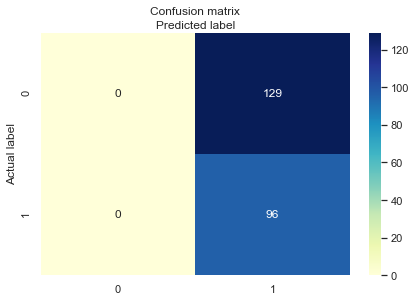

In [106]:
# run accuracy function on the model 
accuracy_metrics(no_corr_df)

Removing the highly correlated variables didn't have an impact on the classification performance of the multilinear model. 

## Multicollinearity Detection: VIF 
It's always possible for collinearity to exist between 3 or more variables even if no single pair of variables have a high correlation. Typically one might use the VIF in order to better assess multicollinearity.A **variance inflation factor(VIF)** detects multicollinearity in regression analysis. Multicollinearity is when there’s correlation between predictors (i.e. independent variables) in a model; it’s presence can adversely affect your regression results. The VIF estimates how much the variance of a regression coefficient is inflated due to multicollinearity in the model. A typical threshold considered for multicollinearity to present a problem is 10. 

In [107]:
# Get variables for which to compute VIF and add intercept term
# set all values in intercept term to 1
X_no_corr = x_df_train
X_no_corr.drop(['Years_Employed', 'Employed', 'Credit_Score'], axis=1, inplace=True)
X_no_corr['Intercept'] = 1
print(X_no_corr.head())

   Gender       Age      Debt   Married  Customer  Education  Ethnicity  \
0     1.0  0.125263  0.031517  0.666667  0.333333   0.142857   0.444444   
1     0.0  0.205564  0.550598  0.666667  0.333333   1.000000   0.444444   
2     0.0  0.659098  0.075945  0.666667  0.333333   0.428571   0.333333   
3     1.0  0.065113  0.208848  0.666667  0.333333   0.642857   0.888889   
4     0.0  0.134135  0.012721  0.666667  0.333333   0.785714   0.888889   

   Prior_Default  Driver_License  Citizen  Zip_Code    Income  Intercept  
0            0.0             1.0      0.0  0.168421  0.000000          1  
1            1.0             0.0      0.0  0.157895  0.000610          1  
2            0.0             0.0      0.0  0.000000  0.000555          1  
3            1.0             0.0      0.0  0.105263  0.000000          1  
4            0.0             0.0      1.0  0.210526  0.000000          1  


In [108]:
# Compute and view VIF
vif = pd.DataFrame()
# using variance inflation factor from Statsmodel
vif['variables'] = X_no_corr.columns
vif["VIF"] = [variance_inflation_factor(X_no_corr.values, i) for i in range(X_no_corr.shape[1])]

In [109]:
print(vif)

         variables         VIF
0           Gender    1.061041
1              Age    1.146484
2             Debt    1.205442
3          Married   13.531726
4         Customer   13.496900
5        Education    1.056574
6        Ethnicity    1.125225
7    Prior_Default    1.238407
8   Driver_License    1.071343
9          Citizen    1.067528
10        Zip_Code    1.132537
11          Income    1.091132
12       Intercept  122.859648


Since Married and Customer have VIF factors above 10, I dropped the Married attribute.  

In [110]:
# drop Marred attribute 
X_no_corr.drop(['Married'], axis=1, inplace=True)

In [111]:
# Compute and view VIF to make sure all interactions are now below 10
# create empty DataFrame
vif = pd.DataFrame()

vif['variables'] = X_no_corr.columns
vif['VIF'] = [variance_inflation_factor(X_no_corr.values, i) for i in range(X_no_corr.shape[1])]
print(vif)

         variables        VIF
0           Gender   1.060396
1              Age   1.146460
2             Debt   1.196301
3         Customer   1.043955
4        Education   1.046141
5        Ethnicity   1.065263
6    Prior_Default   1.234174
7   Driver_License   1.066088
8          Citizen   1.049092
9         Zip_Code   1.132386
10          Income   1.091111
11       Intercept  20.493315


## Rerun Model Again 

In [112]:
predictors_without_corr = ['Gender', 'Age','Debt',
           'Customer', 'Education', 'Ethnicity', 
           'Prior_Default','Driver_License', 
           'Citizen','Zip_Code', 'Income']

In [113]:
no_corr_model = smf.ols(formula='Approved ~ {}'.format(list_to_string(predictors_without_corr)), data=train_df).fit()
print(no_corr_model.summary())

Gender+Age+Debt+Customer+Education+Ethnicity+Prior_Default+Driver_License+Citizen+Zip_Code+Income
                            OLS Regression Results                            
Dep. Variable:               Approved   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     53.85
Date:                Mon, 04 May 2020   Prob (F-statistic):           1.13e-74
Time:                        07:07:53   Log-Likelihood:                -135.15
No. Observations:                 456   AIC:                             294.3
Df Residuals:                     444   BIC:                             343.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

Evaluation Metrics for Multilinear Model
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       129
         1.0       0.43      1.00      0.60        96

    accuracy                           0.43       225
   macro avg       0.21      0.50      0.30       225
weighted avg       0.18      0.43      0.26       225



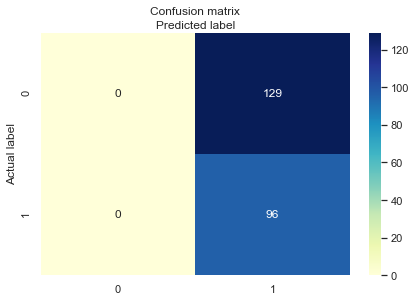

In [114]:
accuracy_metrics(no_corr_df)

Dropping the Married attribute also didn't have an impact on the classification performance of the model.  

## Logistic Regression: 
Logistic Regression is very popular for binary classification. Unlike linear regression, logistic regression will only produce values between 0 and 1. In addition to the predictions, it will be possible to see the probability of a particular classification. I plan to use GridSearching to see if I can make the model perform better by hypertuning the parameters. <br>
I will need to consider collinearity and the correlation of features in the dataset. Discussions like this one indicate that highly correlated features in a logistic regression model wouldn't have an impact on performance, but they would have an impact on interpretation of the coefficients. Generalized linear models tend to perform well with correlated features. I will test to see whether that appears to be the case. https://www.quora.com/Does-the-performance-of-logistic-regression-get-adversely-affected-by-highly-correlated-features

In [115]:
# instantiate a logistic regression model 
# has default parameters 
lr = sklearn.linear_model.LogisticRegression()

In [116]:
# Fit logistic regression model to the training set
# To start with, this model uses all predictors
# using the rescaled version of the data
lr_mod = lr.fit(rescaledX_train, y_train)

In [117]:
# logistic function 
def logistic(model, x):
    z = np.exp(model.intercept_ + model.coef_[0] * x)
    return  z / (1 + z)

## Accuracy Evaluation and Confusion Matrix 

In [118]:
# Use logistic regression to predict instances from the test set and store it
y_hat = lr_mod.predict(rescaledX_test)

In [119]:
# Get the accuracy score of the logistic regression model and print it
print("Accuracy of logistic regression classifier:")
print(classification_report(y_test, y_hat))

Accuracy of logistic regression classifier:
              precision    recall  f1-score   support

         0.0       0.93      0.78      0.85       129
         1.0       0.76      0.92      0.83        96

    accuracy                           0.84       225
   macro avg       0.84      0.85      0.84       225
weighted avg       0.85      0.84      0.84       225



In [120]:
# Print the confusion matrix of the logistic regression model
confusion_matrix = metrics.confusion_matrix(y_test, y_hat)

Text(0.5, 257.44, 'Predicted label')

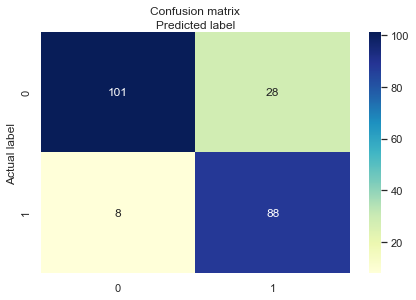

In [121]:
# Create heatmap of confusion matrix 
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [122]:
print(lr_mod.coef_)

[[ 0.10233226 -0.08207781 -0.26714069 -1.45173911 -0.67939558  0.33887635
   0.20892528  1.14025961  3.24901917  0.79153042  0.78461879 -0.34855547
  -0.06220331 -0.78675365  1.57859938]]


## ROC Curve 

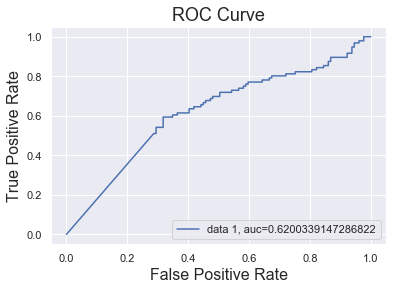

In [123]:
y_hat_proba = lr_mod.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_hat_proba)
auc = metrics.roc_auc_score(y_test, y_hat_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()

## Results Analysis for Logistic Regression
The performance of this model is very similar to the performance of the Simple Linear Regression model with Prior Default as the single predictor. They both have overall accuracy of 0.84 with a F1 score of 0.85 for Denied and 0.83 for Approved. The ROC Curve for this model isn't as far into the left corner, and the AUC is lower at 0.62 compared to 0.85 for the simple linear regression model. This multilinear regression model with all 15 predictors was much better than the multilinear regression model with all predictors that performed poorly.  

## Hyperparameter Tuning 
Parameters are internal characteristics of a model like the regression coefficients that can be estimated from data. **Hyperparameters** are external to the model and have values that can’t be estimated from data. The value of the hyperparameter has to be set before the learning process begins. For example, a hyperparameter is k in k-Nearest Neighbors. I used Grid-search to find the optimal hyperparameters of a model. 

In [124]:
# Define the grid of values for tol and max_iter
tol = [0.01, 0.001, 0.0001]
max_iter = [100, 150, 200]

# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = dict(tol=tol, max_iter=max_iter)

In [125]:
# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=lr_mod, param_grid=param_grid, cv=5)

# Use scaler to rescale X and assign it to rescaledX
rescaledX = scaler.fit_transform(X)

# Fit data to grid_model
grid_model_result = grid_model.fit(rescaledX, y)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.850558 using {'max_iter': 100, 'tol': 0.01}


## Results and Analysis after Hyperparameter Tuning 
Using Hyperparameter Tuning, the accuracy of the logistic regression model increased to 0.8506. 

## Logistic Regression with Cross Validation  
Throughout this project, I have been using train test split where I train the models on a training set and test them on a test set. However, there could be concerns with train test split such as actually getting a random split. With **Cross Validation**, we split our data into k subsets, and train on k-1 of those subsets, holding the last subset for a test. This Stack Overflow post was helpful: https://stackoverflow.com/questions/39163354/evaluating-logistic-regression-with-cross-validation <br>
Using cross validation can help prevent overfitting.  

In [126]:
# convert the DataFrame to a NumPy array
cc_clean = cc_df_clean.values

# Segregate features and labels into separate variables
X,y = cc_clean[:,0:15] , cc_clean[:,15]

In [127]:
# instantiate a logistic regression model with cross validation
# has default parameters 
logreg= sklearn.linear_model.LogisticRegression()

In [128]:
# need to look into more hyperparameter tuning
# or scale data with Standard Scaler so it is more norally distributed 
# for now, turned off ConvergenceWarning based on: 
# https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
predicted = cross_val_predict(logreg, X, y, cv=10)

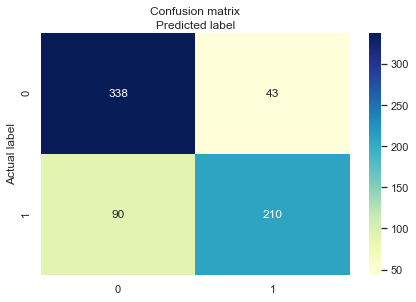

In [129]:
# Print the confusion matrix of the logistic regression model
confusion_matrix_cv = metrics.confusion_matrix(y, predicted)
heatmap(confusion_matrix_cv)

In [130]:
print(classification_report(y, predicted))

              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84       381
         1.0       0.83      0.70      0.76       300

    accuracy                           0.80       681
   macro avg       0.81      0.79      0.80       681
weighted avg       0.81      0.80      0.80       681



## Results and Analysis for Cross Validation
Cross Validation produced similar results to the train test split. In the future, I could use cross validation throughout the project to prevent overfitting. Using this particular method, I received ConvergenceWarnings. It might be beneficial to scale the data with StandardScaler so it is normally distributed. Otherwise, I might need to adjust the hyperparameters like increase max_iter. 

## Selecting Which Features to Use for the Model 
For the simple linear regression model, the Prior Default Model produced very accurate results. In selecting which features to use for the logistic regression model, I started with single variable logistic regression to see if the results are similar to the single linear regression. 

## Single Variable Logistic Regression

In [131]:
def single_variate_logistic_regression(i, train_df, test_df):
    lr = sklearn.linear_model.LogisticRegression()
    X_train = train_df[i].to_numpy()
    y_train = train_df['Approved'].to_numpy()
    lr_mod = lr.fit(X_train.reshape(-1,1), y_train)
    
    # Use logistic regression to predict instances from the test set and store it
    X_test = test_df[i].to_numpy()
    y_test = test_df['Approved'].to_numpy()
    y_hat = lr_mod.predict(X_test.reshape(-1,1))
    yhat_p = lr_mod.predict_proba(X_test.reshape(-1,1))
    
    # graph of logistic function
    plt.plot(X_test,y_test,'ro');
    plt.xlabel(i)
    plt.ylabel('Approved');
    
    x = np.linspace(np.amin(X_test),np.amax(X_test),1000)
    y = logistic(lr_mod, x)
    plt.axhline(0.5, ls='--')
    plt.plot(x, y);
    
    print(f"Evaluation Metrics for Variable {i}")
    print(classification_report(y_test, y_hat, zero_division=0))
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_hat)
    heatmap(confusion_matrix)

In [132]:
# print('intercept:', clf.intercept_)
# print('coefficient:', clf.coef_[0])

Evaluation Metrics for Variable Gender
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       129
         1.0       0.00      0.00      0.00        96

    accuracy                           0.57       225
   macro avg       0.29      0.50      0.36       225
weighted avg       0.33      0.57      0.42       225



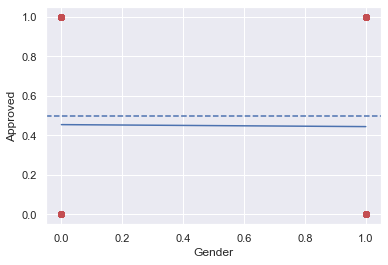

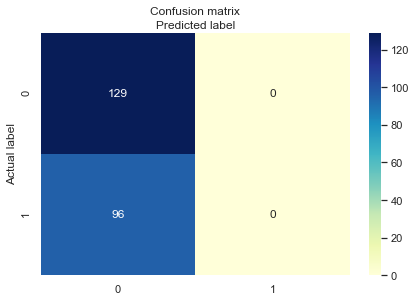

Evaluation Metrics for Variable Age
              precision    recall  f1-score   support

         0.0       0.61      0.88      0.72       129
         1.0       0.61      0.24      0.34        96

    accuracy                           0.61       225
   macro avg       0.61      0.56      0.53       225
weighted avg       0.61      0.61      0.56       225



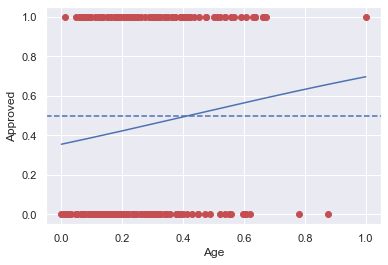

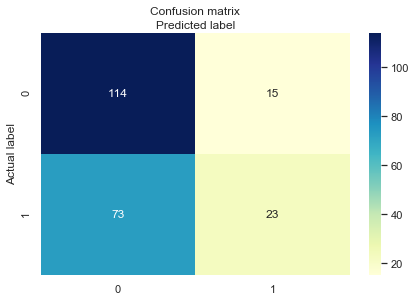

Evaluation Metrics for Variable Debt
              precision    recall  f1-score   support

         0.0       0.62      0.84      0.71       129
         1.0       0.59      0.31      0.41        96

    accuracy                           0.61       225
   macro avg       0.60      0.57      0.56       225
weighted avg       0.61      0.61      0.58       225



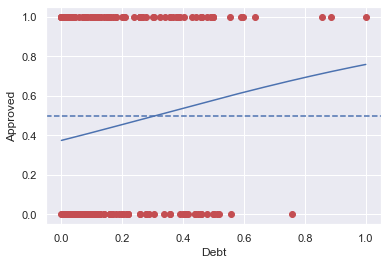

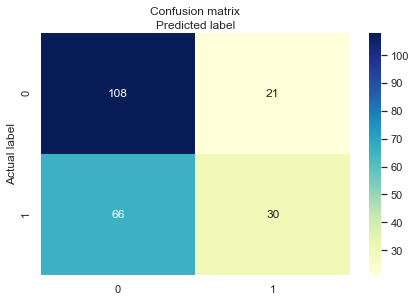

Evaluation Metrics for Variable Married
              precision    recall  f1-score   support

         0.0       0.58      0.99      0.73       129
         1.0       0.67      0.02      0.04        96

    accuracy                           0.58       225
   macro avg       0.62      0.51      0.38       225
weighted avg       0.62      0.58      0.44       225



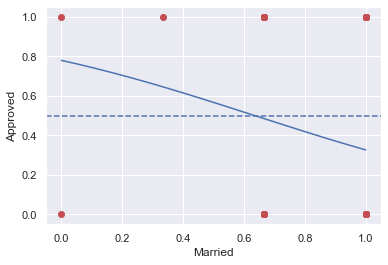

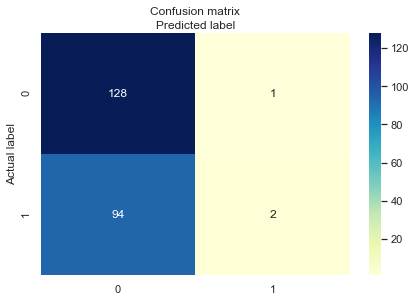

Evaluation Metrics for Variable Customer
              precision    recall  f1-score   support

         0.0       0.57      0.99      0.73       129
         1.0       0.50      0.01      0.02        96

    accuracy                           0.57       225
   macro avg       0.54      0.50      0.37       225
weighted avg       0.54      0.57      0.43       225



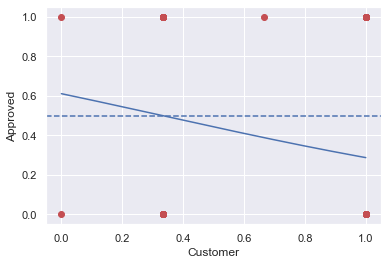

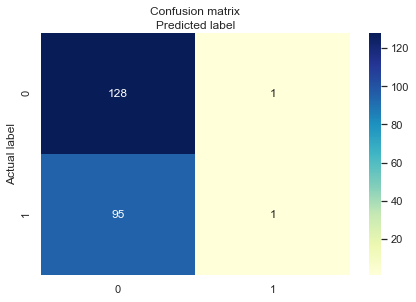

Evaluation Metrics for Variable Education
              precision    recall  f1-score   support

         0.0       0.63      0.82      0.72       129
         1.0       0.60      0.36      0.45        96

    accuracy                           0.63       225
   macro avg       0.62      0.59      0.59       225
weighted avg       0.62      0.63      0.60       225



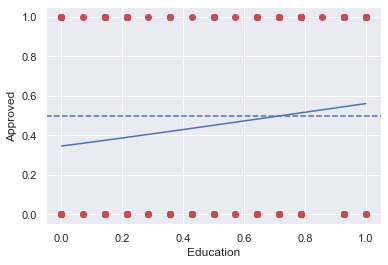

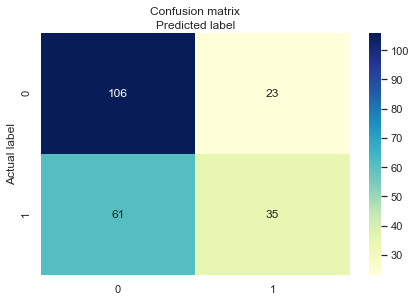

Evaluation Metrics for Variable Ethnicity
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       129
         1.0       0.00      0.00      0.00        96

    accuracy                           0.57       225
   macro avg       0.29      0.50      0.36       225
weighted avg       0.33      0.57      0.42       225



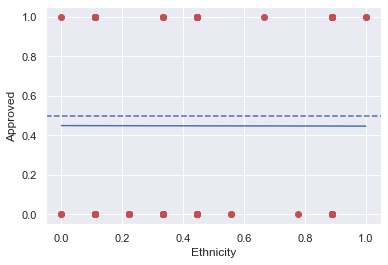

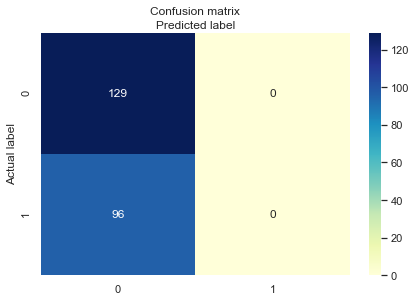

Evaluation Metrics for Variable Years_Employed
              precision    recall  f1-score   support

         0.0       0.65      0.88      0.74       129
         1.0       0.68      0.35      0.47        96

    accuracy                           0.65       225
   macro avg       0.66      0.62      0.60       225
weighted avg       0.66      0.65      0.62       225



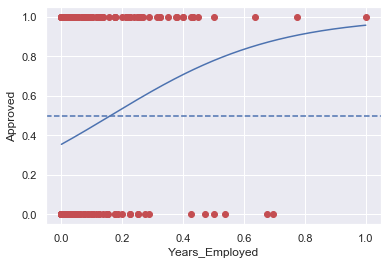

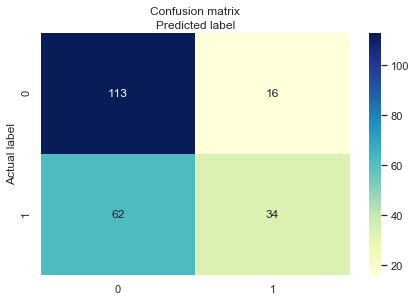

Evaluation Metrics for Variable Prior_Default
              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85       129
         1.0       0.75      0.94      0.83        96

    accuracy                           0.84       225
   macro avg       0.85      0.85      0.84       225
weighted avg       0.86      0.84      0.84       225



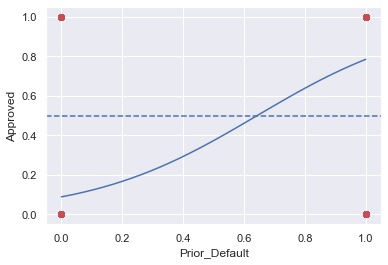

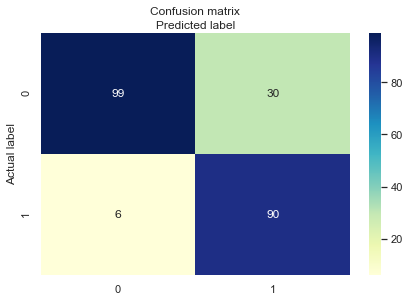

Evaluation Metrics for Variable Employed
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78       129
         1.0       0.70      0.70      0.70        96

    accuracy                           0.74       225
   macro avg       0.74      0.74      0.74       225
weighted avg       0.74      0.74      0.74       225



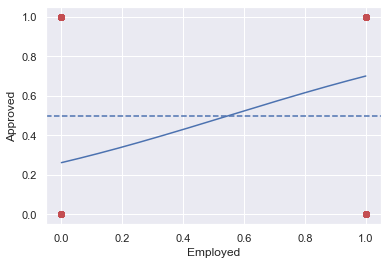

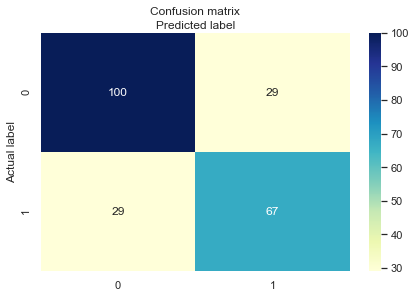

Evaluation Metrics for Variable Credit_Score
              precision    recall  f1-score   support

         0.0       0.70      0.99      0.82       129
         1.0       0.98      0.43      0.59        96

    accuracy                           0.75       225
   macro avg       0.84      0.71      0.71       225
weighted avg       0.82      0.75      0.72       225



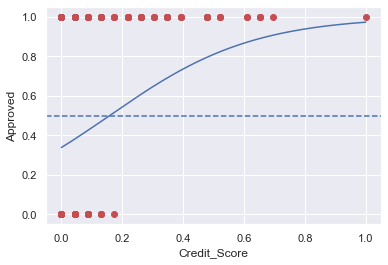

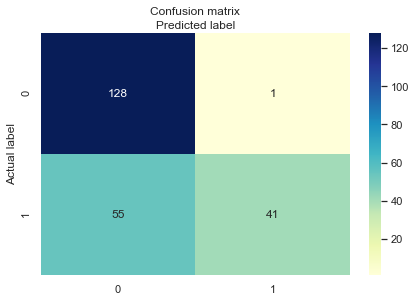

Evaluation Metrics for Variable Driver_License
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       129
         1.0       0.00      0.00      0.00        96

    accuracy                           0.57       225
   macro avg       0.29      0.50      0.36       225
weighted avg       0.33      0.57      0.42       225



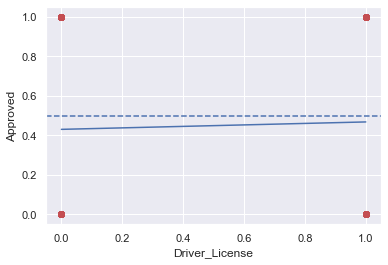

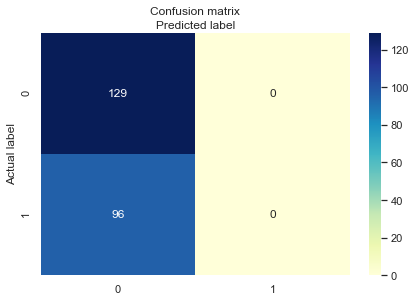

Evaluation Metrics for Variable Citizen
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       129
         1.0       0.00      0.00      0.00        96

    accuracy                           0.57       225
   macro avg       0.29      0.50      0.36       225
weighted avg       0.33      0.57      0.42       225



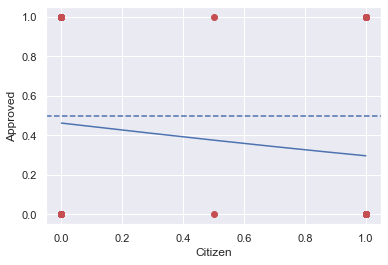

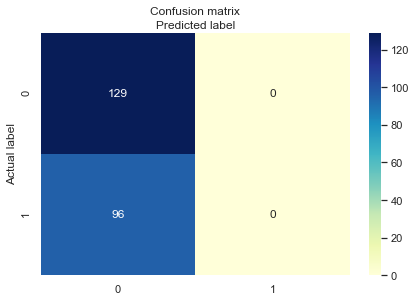

Evaluation Metrics for Variable Zip_Code
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       129
         1.0       0.00      0.00      0.00        96

    accuracy                           0.57       225
   macro avg       0.29      0.50      0.36       225
weighted avg       0.33      0.57      0.42       225



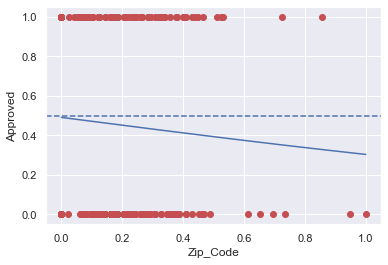

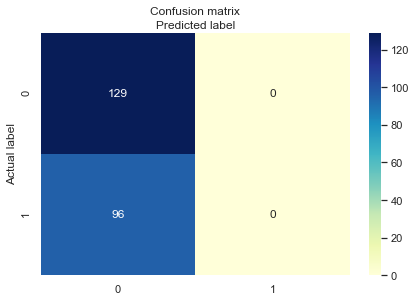

Evaluation Metrics for Variable Income
              precision    recall  f1-score   support

         0.0       0.61      0.91      0.73       129
         1.0       0.65      0.23      0.34        96

    accuracy                           0.62       225
   macro avg       0.63      0.57      0.53       225
weighted avg       0.63      0.62      0.56       225



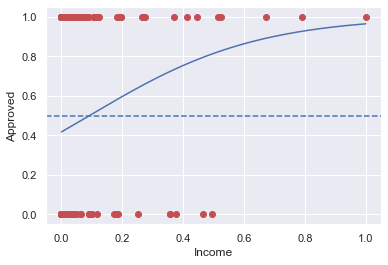

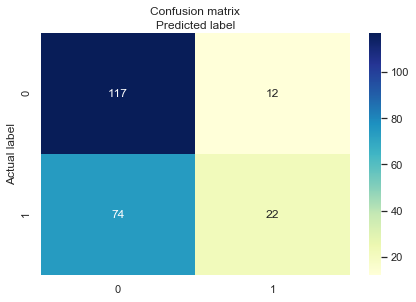

In [133]:
for i in predictors:
    single_variate_logistic_regression(i, train_df, test_df)

## Multilinear Logistic Regression, Remove Variables with Collinearity
I am hypothesizing that removing variables with collinearity will not effect the performance of the logistic regression model although it could make itnerpreting the coefficients more difficult. SInce my focus is on prediction for this project, I see whether removing correlated predictors impacts the performance of the model. 

In [134]:
# predictors in the dataset 
predictors_without_corr = ['Gender', 'Age','Debt','Customer', 
          'Education', 'Ethnicity','Prior_Default', 
          'Driver_License', 'Citizen','Zip_Code', 
          'Income']

In [135]:
# instantiate a logistic regression model 
# has default parameters 
lr = sklearn.linear_model.LogisticRegression()
X_train_no_corr = train_df[predictors_without_corr].to_numpy()
y_train_no_corr = train_df['Approved'].to_numpy()
lr_multi = lr.fit(X_train_no_corr, y_train_no_corr)
    
# Use logistic regression to predict instances from the test set and store it
X_test_no_corr = test_df[predictors_without_corr].to_numpy()
y_test_no_corr = test_df['Approved'].to_numpy()
y_hat_no_corr = lr_multi.predict(X_test_no_corr)
#yhat_p = lr_mod.predict_proba(X_test.reshape(-1,1))

In [136]:
print(classification_report(y_test_no_corr, y_hat_no_corr))

              precision    recall  f1-score   support

         0.0       0.93      0.77      0.84       129
         1.0       0.75      0.93      0.83        96

    accuracy                           0.84       225
   macro avg       0.84      0.85      0.84       225
weighted avg       0.85      0.84      0.84       225



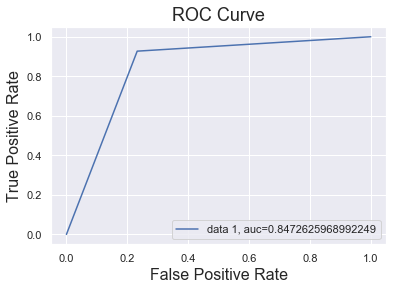

In [137]:
fpr, tpr, _ = metrics.roc_curve(y_test_no_corr,  y_hat_no_corr)
auc = metrics.roc_auc_score(y_test_no_corr, y_hat_no_corr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()

The F1 and accuracy scores are nearly identical to the model with all predictors. 

## Recursive Feature Elimination 
**Recursive Feature Elimination (RFE)** is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features. <br>
From the single logistic regression models, Prior Default appears extremeley important once again. The performance of a model with only Prior Default is on par with performance of a logistic regression model with all predictors. I test whether there is any performance benefit to having Prior Default and a couple other variables in the model. 

## Test 3 Features 

In [138]:
# if there isn't a value for number of features to select
# default is to select half the features
lr = sklearn.linear_model.LogisticRegression()
rfe = RFE(lr, 3)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
print(predictors)

[False False False  True False False False False  True  True False False
 False False False]
[ 8 11 10  1  3  9  7  4  1  1  6  2  5 12 13]
['Gender', 'Age', 'Debt', 'Married', 'Customer', 'Education', 'Ethnicity', 'Years_Employed', 'Prior_Default', 'Employed', 'Credit_Score', 'Driver_License', 'Citizen', 'Zip_Code', 'Income']


In [139]:
# using enumerate() 
# to find indices for 3 
res_list = [i for i, value in enumerate(rfe.ranking_) if value == 1] 
print(res_list)

[3, 8, 9]


In [140]:
selected_features = []
for i in res_list:
    selected_features.append(predictors[i])
print(selected_features)

['Married', 'Prior_Default', 'Employed']


In [141]:
X_select = train_df[selected_features]
y_select = train_df['Approved']

In [142]:
logit_model=sm.Logit(y_select,X_select)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.344213
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.499     
Dependent Variable: Approved         AIC:              319.9226  
Date:               2020-05-04 07:08 BIC:              332.2900  
No. Observations:   456              Log-Likelihood:   -156.96   
Df Model:           2                LL-Null:          -313.54   
Df Residuals:       453              LLR p-value:      9.9298e-69
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Married          -4.0581   0.3967 -10.2303 0.0000 -4.8356 -3.2807
Prior_Default     3.8287   0.3352  11.4234 0.0000  3.1718  4.4856


In [143]:
# instantiate a logistic regression model 
# has default parameters 
lr = sklearn.linear_model.LogisticRegression()
X_train_rfe = X_select.to_numpy()
y_train_rfe = y_select.to_numpy()
lr_multi = lr.fit(X_train_rfe, y_train_rfe)
    
# Use logistic regression to predict instances from the test set and store it
X_test_rfe = test_df[selected_features].to_numpy()
y_test_rfe = test_df['Approved'].to_numpy()
y_hat_rfe = lr_multi.predict(X_test_rfe)
#yhat_p = lr_mod.predict_proba(X_test.reshape(-1,1))

In [144]:
print(classification_report(y_test_rfe, y_hat_rfe, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85       129
         1.0       0.75      0.94      0.83        96

    accuracy                           0.84       225
   macro avg       0.85      0.85      0.84       225
weighted avg       0.86      0.84      0.84       225



All coefficients are statistically significant. Accuracy metrics simlar to single variable model with Prior Default. 

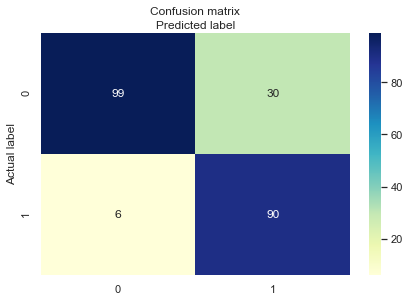

In [145]:
#Print the confusion matrix of the logistic regression model
confusion_matrix = metrics.confusion_matrix(y_test_rfe, y_hat_rfe)
heatmap(confusion_matrix)

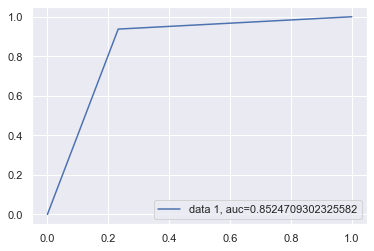

In [146]:
fpr, tpr, _ = metrics.roc_curve(y_test_rfe, y_hat_rfe)
auc = metrics.roc_auc_score(y_test, y_hat_rfe)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Test Two Features 

In [147]:
# if there isn't a value for number of features to select
# default is to select half the features
lr = sklearn.linear_model.LogisticRegression()
rfe = RFE(lr, 2)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
print(predictors)

[False False False  True False False False False  True False False False
 False False False]
[ 9 12 11  1  4 10  8  5  1  2  7  3  6 13 14]
['Gender', 'Age', 'Debt', 'Married', 'Customer', 'Education', 'Ethnicity', 'Years_Employed', 'Prior_Default', 'Employed', 'Credit_Score', 'Driver_License', 'Citizen', 'Zip_Code', 'Income']


In [148]:
# using enumerate() 
# to find indices for 3 
res_list = [i for i, value in enumerate(rfe.ranking_) if value == 1] 
print(res_list)

[3, 8]


In [149]:
selected_features = []
for i in res_list:
    selected_features.append(predictors[i])
print(selected_features)

['Married', 'Prior_Default']


In [150]:
X_select = train_df[selected_features]
y_select = train_df['Approved']

In [151]:
logit_model=sm.Logit(y_select,X_select)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.359954
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.477     
Dependent Variable: Approved         AIC:              332.2781  
Date:               2020-05-04 07:08 BIC:              340.5231  
No. Observations:   456              Log-Likelihood:   -164.14   
Df Model:           1                LL-Null:          -313.54   
Df Residuals:       454              LLR p-value:      5.9844e-67
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Married           -3.6762   0.3697 -9.9444 0.0000 -4.4008 -2.9517
Prior_Default      4.1462   0.3298 12.5727 0.0000  3.4999  4.7926


In [152]:
# instantiate a logistic regression model 
# has default parameters 
lr = sklearn.linear_model.LogisticRegression()
X_train_rfe = X_select.to_numpy()
y_train_rfe = y_select.to_numpy()
lr_multi = lr.fit(X_train_rfe, y_train_rfe)
    
# Use logistic regression to predict instances from the test set and store it
X_test_rfe = test_df[selected_features].to_numpy()
y_test_rfe = test_df['Approved'].to_numpy()
y_hat_rfe = lr_multi.predict(X_test_rfe)
#yhat_p = lr_mod.predict_proba(X_test.reshape(-1,1))

In [153]:
print(classification_report(y_test_rfe, y_hat_rfe, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85       129
         1.0       0.75      0.94      0.83        96

    accuracy                           0.84       225
   macro avg       0.85      0.85      0.84       225
weighted avg       0.86      0.84      0.84       225



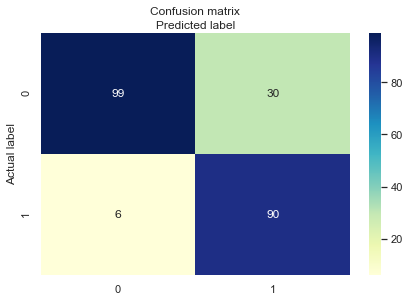

In [154]:
#Print the confusion matrix of the logistic regression model
confusion_matrix = metrics.confusion_matrix(y_test_rfe, y_hat_rfe)
heatmap(confusion_matrix)

Adding additional features doesn't show improvement over metrics for logistic regression or linear regression models with Prior Default variable alone. 

## KNN
Nearest neighbor averaging can be pretty good for small p (i.e. p<= 4) and large-is N. Nearest neighbor methods can be lousy when p is large due to the curse of dimensionality. Nearest neighbors tend to be far away in high dimensions. For this dataset, p = 15 and n is relatively small at less than a 1000 so I am anticipating that a flexible model won't provide the best fit.

## Hyperparamter Tuning: Selecting the Value of K 

In [155]:
# choosing the optimal value of k is critical 
# Try running from k=1 through 25 and record testing accuracy
k_range = range(1, 26)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_hat = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, y_hat)
    scores_list.append(metrics.accuracy_score(y_test, y_hat))

Text(0, 0.5, 'Testing Accuracy')

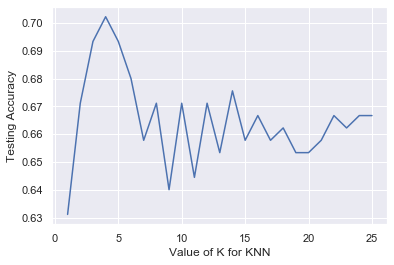

In [156]:
# plot the relationship between K and the testing accuracy 
plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

Based on graph, use value of 4 for K. 

In [157]:
# create instance of classifier with specified parameters
# to start, use 4 nearest neighbors 
# uniform weight method means treat each point equally 
# no matter the distance from point we are classifying 
clf = neighbors.KNeighborsClassifier(n_neighbors=4, weights='uniform')

In [158]:
# fit classifier to the training dataset 
clf.fit(rescaledX_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [159]:
y_hat = clf.predict(X_test)

In [160]:
print(classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.69      0.68      0.68       129
         1.0       0.58      0.58      0.58        96

    accuracy                           0.64       225
   macro avg       0.63      0.63      0.63       225
weighted avg       0.64      0.64      0.64       225



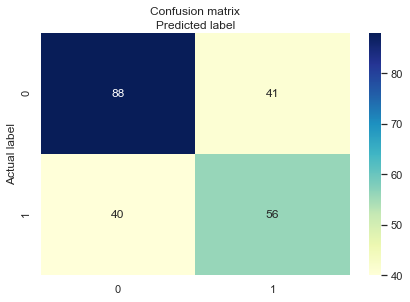

In [161]:
#Print the confusion matrix of the logistic regression model
confusion_matrix = metrics.confusion_matrix(y_test, y_hat)
heatmap(confusion_matrix)

The F1 and accuracy metrics fall short of the logistic or linear regression models based only on Prior Default, or the logistic regression model with all predictors. While the overall prcision and recall of this model might be problematic for real use, the results seem better than a model that only approves or denies everyone. 

## Models From Outside of Class
In the lecture about Bias-Variance Trade-off, and the differences betweeen flexible and inflexible models, there was a slide with different types of models. I was interested by Trees because they were in the middle of the slide in terms of flexibility, more flexible than least squares linear models but less flexible than  technqiues like Bagging and Boosting. SVM was on the slide as very flexible. GIven the small n, largist p of 15 predictors, I was thinking that flexible models wouldn't perform well for our dataset. 

## Decision Tree Classification

In [162]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [163]:
y_pred = classifier.predict(X_test)

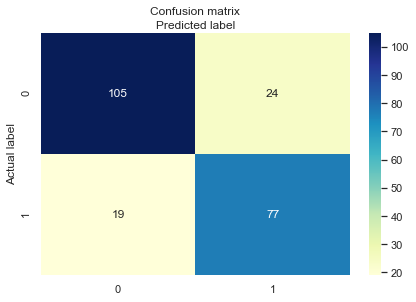

In [164]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
heatmap(confusion_matrix)

In [165]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83       129
         1.0       0.76      0.80      0.78        96

    accuracy                           0.81       225
   macro avg       0.80      0.81      0.81       225
weighted avg       0.81      0.81      0.81       225



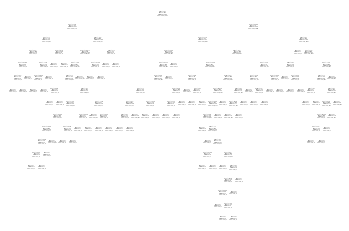

In [166]:
tree.plot_tree(classifier);

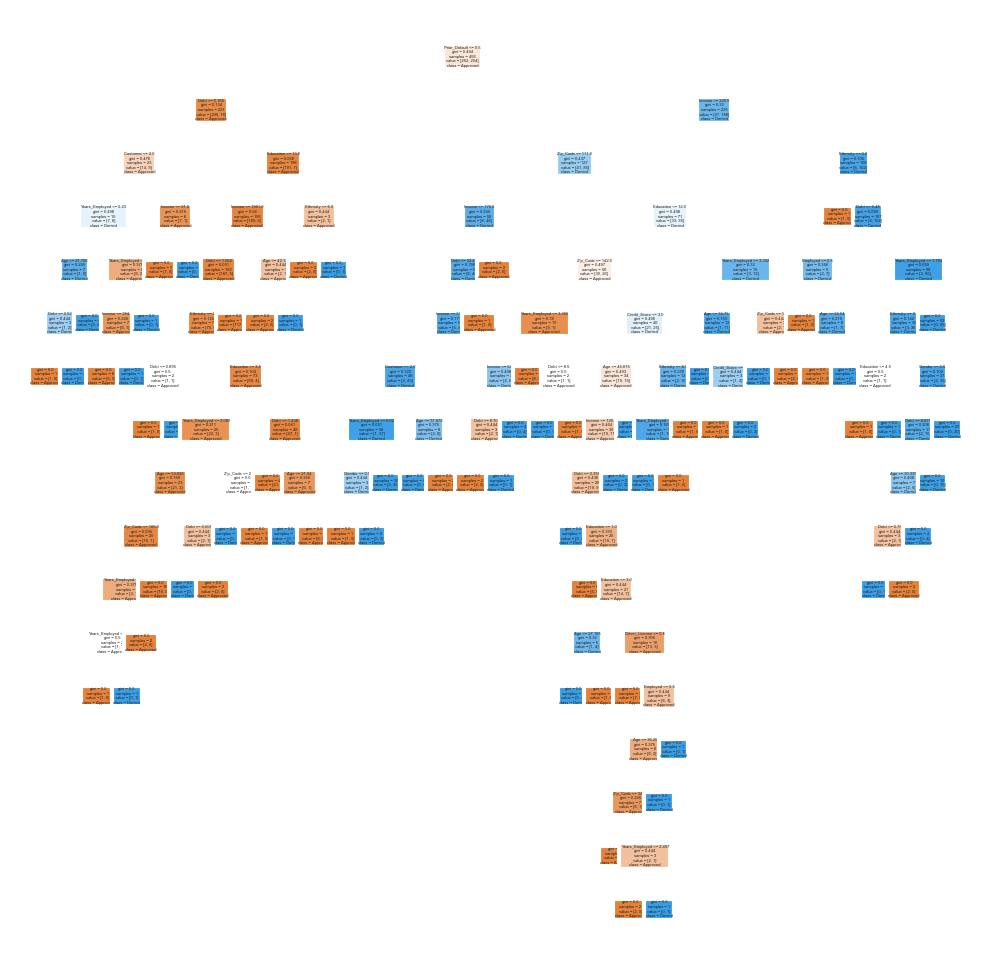

In [167]:
cn=['Approved', 'Denied']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(classifier,
               feature_names = predictors, 
               class_names=cn,
               filled = True);
fig.savefig('cc_decisiontree.png')

## Support Vector Machines
The core idea of SVM is to find a maximum marginal hyperplane (MMH) that best divides the dataset into classes. Support vectors are the data points closest to the hyperplane. A hyperplane is a decision plane which separates a set of objects having different class memberships. A margin is a gap between the two lines on the closest class points. Margin is calculated as the perpendicular distance from the line to support vectors or closest points. A larger margin between classes is preferable to a smaller margin between classes. 

In [168]:
#Create a svm Classifier

svm_clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
# need to use scaled data
svm_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svm_clf.predict(X_test)

In [169]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.81       129
         1.0       0.71      0.96      0.81        96

    accuracy                           0.81       225
   macro avg       0.83      0.83      0.81       225
weighted avg       0.85      0.81      0.81       225



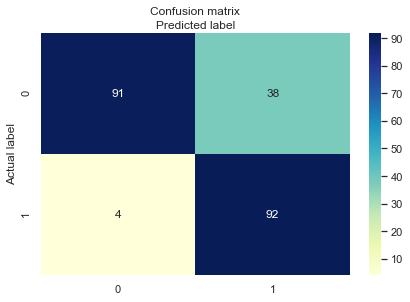

In [170]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
heatmap(confusion_matrix)

Despite being flexible models, both the DDecision Tree and SVM had high F1 and accuracy scores over 80%. I would improve by making sure that the tree wasn't overfit by having so many levels. 

## Discussion and Conclusion 
Ultimately, this project produced somewhat different results than I anticipated. During the EDA, I realized that the Prior Default variable had a high Chi square score of 170 with the target variable. However, other predictors were also correlated with the target variable so at the beginning of the project, I didn't realize how large of a role the Prior Default variable would play in models predicting approval decisions. I correctly hypothesized that Gender, Ethnicity, and Driver’s License wouldn't have a large influence, but I thought that Employment would have an influence in addition to Prior Default.  
+ I anticipated that a simple linear model would not be a robust enough classifier for many of the predictors in the dataset. This was true. I created a simple linear regression model with every predictor in the dataset. The results demonstrated the importance of not relying only on accuracy for a problem with real world applications like this one. In terms of issuing credit, a financial institution would need to evaluate whether it was more costly for them to accidentally approve someone who might default or deny someone credit who should have been approved. Precision and recall metrics are particularly important because certain models could have better accuracy than the null model of classifyng everyone to the most common class, but still be in essence worthless because they denied or approved every applicant. For the sake of this project, I readily used the F1 statistic because I appreciated that it took into account both preicison and recall. However, for real life purposes it might be smarter to choose a metric that didn't treat the precision and recall as equally relevant.   
+ Given the small n of 690 data objects in the dataset as well as the relatively large number of p = 15, it seemed like an inflexible model might have an advatange over a flexible one that would suffer from the curse of dimensionality. This section of the project hammered home the idea of simplicity. Since there were 15 predictors in the dataset, it was tempting for me to think that the best model would be relatively complicated and incorporate a number of variables. However, a simple linear regression model with Prior Default as the predictor had F1 scores of 0.85 for Denied and 0.83 for Approved with an overall accuracy score of 0.84. This performance was matched, but not exceeded by the ther models in the project.
+ When I tried to include a multilinear model with all of the predictors, it overfitted the training data and performed very poorly with all applications approved (leading to 0.43 accuracy overall when classifying to the most frequent class would have been over 50% accuracte). Interstingly, taking a similar approach with a logistic regression function and putting all predictors into it had a matching accuracy to the linear regression model with only Prior Default. I used Recursive Feature Elimination for feature selection and realized that logistic functions with Prior Default performed on par with models containing more features. 
+ I was concerned about the effect of collinearity on the regression models. For the linear regression models, the Prior Default variable played such an important role that ultimately removing highly corelated variables did not have an effect. For the logistic regression, it seemed that collinearity was not a problem for prediction but could have increased the difficulty of interpreting the variables.  
+ I was concerned that KNN would struggle with the curse of dimensionality given the large number of predictors and small number of n. As anticipated, the KNN performace was not as good as logistic regression with all of the predictors. 

### Suggest Ways to Improve:
+ For binary classificaton, LDA and Linear Regression have a relationship: "There is a considerable and meaningful relation between linear regression and linear discriminant analysis. In case the dependent variable (DV) consists just of 2 groups the two analyses are actually identical. Despite that computations are different and the results - regression and discriminant coefficients - are not the same, they are exactly proportional to each other." I know that LDA is useful when n is small or the classes are well separated. Logistic regression becomes unstable if classes are well separated so I would be curious to try out LDA, compare the results to linear regression, and then see if that offers any additional insights into the performacne of the lienar regression models on this dataset. 

+ Given the way Prior Default can be used to classify the data, I am interested what I could do to improve accuracy beyond the current models I explored. 

+ I was also curious to try a Naive Bayes Classifier. Even though an assumption of class independence doesn't seem like it would actually hold for the data, I have heard that Naive Bayes perform well even if conditional independence assumptions don't hold. I know that Naive Bayes can offer some advantages for large p. Even though p = 15 is actually relatively small, I would be interested to try it out. 

+ When I initially looked at the data, I thought that many of the numeric values were right skewed. Upon further inspection, I realized that some of the variables had large quantities of zero values. It seems like some of the variables like income might be log-normal. One improvement would be exploring how to best transform this data (particularly given the large number of zero values), or further evaluating whether that would be necessary. 
